Generative Models
***

**MIPT, Autumn 2022, MSc course**


## Assignment 1

***


*Authored by Arip Asadulaev & Manh Lab*

*Adapted by Alexander Panfilov*

***


The assignment is split into two parts: at first, you will implement classical GAN for the MNIST dataset, and after, you will enhance your results with DCGAN and the CIFAR dataset. 

Good luck!

## 1. GAN
*Source: <a href="https://arxiv.org/pdf/1406.2661.pdf" target="_blank">Goodfellow, Ian J., et al. "Generative Adversarial Networks." arXiv preprint arXiv:1406.2661 (2014)</a>.*

In 2014, Ian Goodfellow and his colleagues at the University of Montreal published a stunning paper introducing the world to GANs, or generative adversarial networks. The models play two distinct (literally, adversarial) roles. Given some real data set $\mathcal{X}$, $G$ is the generator, trying to create fake data that looks just like the genuine data, while $D$ is the discriminator, getting data from either the real set or $G$ and labeling the difference.

Goodfellow’s metaphor (and a fine one it is) was that $G$ was like a team of forgers trying to match real paintings with their output, while $D$ was the team of detectives trying to tell the difference. (Except in this case, the forgers $G$ never get to see the original data — only the judgments of $D$. They’re like blind forgers.)

<img src="https://production-media.paperswithcode.com/methods/gan.jpeg" style="display=block; margin:auto"/>
<p style="text-align: center">
    <b>Picture taken from the <a href="https://paperswithcode.com/method/gan" target="_blank">paperswithcode</a> website. There you can find a whole bunch of papers on GANs with implementation.</b>
</p>

In this part, we are going to implement classical GAN. You can find a rough plan on how to do it below; however, it is not mandatory to stick with it precisely but one might expect some questions related to the listed steps. Feel free to adapt provided code!

- Define the parameters
- Load the data (with transforms and normalization)
- Denormalize for visual inspection of samples
- Define the Discriminator network, the Generator network
- Study the activation function: Leaky ReLU
- Explain the output activation function: Tanh, Sigmoid
- Look at some sample outputs
- Define losses, optimizers and helper functions for training
     - For Discriminator
     - For Generator
- Train the model
- Save intermediate generated images to file
- Look at some outputs
- Save the models

### Imports

In [94]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
from torchvision.datasets import CIFAR10, MNIST
from torchvision.transforms import Compose, Normalize, ToTensor
from torchvision.utils import save_image
from tqdm import tqdm

%matplotlib inline
plt.style.use("ggplot")

### Define parameters & data loading 

In [2]:
hidden_size = 256
batch_size = 100
LR = 0.0002
num_epochs = 300
sample_dir = "./images"
latent_size = 64  # input random input vector latent
image_size = 784  # 28*28 flatten
device = "cuda" if torch.cuda.is_available() else "cpu"

if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)
## Define the dataset
mnist_dataset = MNIST(
    root="data",
    train=True,
    download=True,
    transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]),
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Label:  5


(array([55.,  4.,  3.,  0.,  3.,  2.,  1.,  0.,  1.,  3.,  1.,  3.,  2.,
         1., 21.]),
 array([-1.        , -0.86771244, -0.7354248 , -0.60313725, -0.47084966,
        -0.3385621 , -0.20627451, -0.07398693,  0.05830066,  0.19058824,
         0.32287583,  0.4551634 ,  0.587451  ,  0.71973854,  0.85202616,
         0.9843137 ], dtype=float32),
 <a list of 15 Patch objects>)

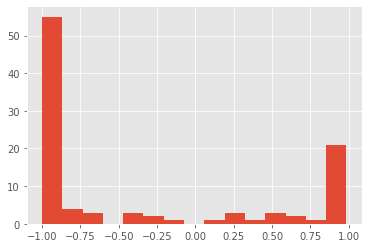

In [3]:
img, label = mnist_dataset[0]
print("Label: ", label)
plt.hist(img[:, 5:15, 5:15].flatten(), bins=15)

In [4]:
# denormalization image from range (-1)-1 to range 0-1 to display it
def denorm(x):
    x = (x + 1) / 2
    return x

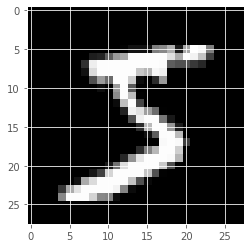

In [5]:
# show image sample with matplotlib
plt.imshow(denorm(img).squeeze(), cmap="gray")

In [6]:
# define the dataloader
from torch.utils.data import DataLoader

In [105]:
dataloader = DataLoader(
    mnist_dataset, batch_size=batch_size, shuffle=True 
    )

### GAN implementation

GAN consists of two deep networks, a generator ($G$) and a discriminator ($D$). The generator creates images before learning it. Since the discriminator is a binary classification model, we can use the binary cross-entropy loss function to quantify how well it can distinguish between real and generated images.

In [106]:
class Generator(nn.Module):
    def __init__(self, latent_size, image_size, hidden_size):
        super(Generator, self).__init__()
        ## set a linear layer with input size is latent_size and output size is hidden_size
        self.linear1 = nn.Linear(latent_size, hidden_size)
        # set a linear layer with input size is hidden_size and output size is hidden_size
        self.linear2 = nn.Linear(hidden_size, hidden_size)

        # set a linear layer with input size is hidden_size and output size is image_size
        self.linear3 = nn.Linear(hidden_size, image_size)

    def forward(self, x):
        # forward x -> linear1 -> relu -> linear2 -> relu -> linear3 -> tanh
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = torch.tanh(self.linear3(x))
        return x


class Discriminator(nn.Module):
    def __init__(self, image_size, hidden_size):
        super(Discriminator, self).__init__()
        ## set a linear layer with input size is image_size and output size is hidden_size
        self.linear1 = nn.Linear(image_size, hidden_size)

        # set a linear layer with input size is hidden_size and output size is hidden_size
        self.linear2 = nn.Linear(hidden_size, hidden_size)

        # set a linear layer with input size is hidden_size and output size is 1
        self.linear3 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # forward x -> linear1 -> relu -> linear2 -> relu -> linear3 -> sigmoid
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.sigmoid(self.linear3(x))
        return x

### Create the Generator and Discriminator

In [107]:
# create new Generator model

G = Generator(latent_size, image_size, hidden_size).to(device)

# create new Discriminator model

D = Discriminator(image_size, hidden_size).to(device)

In [108]:
# show the output of model
y = G(torch.randn(2, latent_size).to(device))

In [109]:
y.shape

torch.Size([2, 784])

In [110]:
# define the criterion is nn.BCELoss()
criterion = nn.BCELoss()

## Define the optimizer for generator and discrimator
G_optimizer = torch.optim.AdamW(G.parameters(), lr=LR)
D_optimizer = torch.optim.AdamW(D.parameters(), lr=LR)

Discriminator Training

In [111]:
def reset_grad():
    ## reset gradient for optimizer of generator and discrimator
    G_optimizer.zero_grad()
    D_optimizer.zero_grad()
    
def train_discriminator(D_model, G_model, images):
  
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
        
    
    outputs = D_model(images)
    # Loss for real images
    
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G_model(z)
    outputs = D_model(fake_images)

    fake_score = outputs

    # Sum losses
    real_loss = criterion(real_score, real_labels)
    fake_loss = criterion(fake_score, fake_labels)
    d_loss = real_loss + fake_loss  

    # Reset gradients
    reset_grad()

    # Compute gradients
    d_loss.backward()

    # Adjust the parameters using backprop
    D_optimizer.step()
    
    return d_loss, real_score, fake_score

Generator Training

In [112]:
def train_generator(G_model, D_model):
    # Generate fake images and calculate loss
    # z = torch.randn(batch_size, latent_size).to(device)
    z = torch.Tensor(np.random.normal(0, 1, (batch_size, latent_size))).to(device)
    fake_images = G_model(z)
    labels = torch.ones(batch_size, 1).to(device)
    
    # calculate the generator loss
    g_loss = criterion(D_model(fake_images), labels)

    # Reset gradients
    reset_grad()

    # Backprop and optimize
    g_loss.backward()
    G_optimizer.step()

    return g_loss, fake_images

### Start the training proccess

In [113]:
# function to save the sample output of generator
def save_fake_images_mnist(G_model, index):
    # sample_vectors = torch.randn(batch_size, latent_size).to(device)
    sample_vectors = torch.Tensor(np.random.normal(0, 1, (batch_size, latent_size))).to(
        device
    )
    fake_images = G_model(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = "fake_images-{0:0=4d}.png".format(index)
    print("Saving", fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

In [63]:
%%time
total_step = len(dataloader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
G.to(device)
D.to(device)
for epoch in tqdm(range(num_epochs)):
    for i, (images, _) in enumerate(dataloader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator
        d_loss, real_score, fake_score = train_discriminator(D, G, images)

        # Train the generator
        g_loss, fake_images = train_generator(G, D)

        # Inspect the losses
        if (i + 1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print(
                "Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}".format(
                    epoch,
                    num_epochs,
                    i + 1,
                    total_step,
                    d_loss.item(),
                    g_loss.item(),
                    real_score.mean().item(),
                    fake_score.mean().item(),
                )
            )
    # Sample and save images
    save_fake_images_mnist(G, epoch + 1)

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch [0/300], Step [200/600], d_loss: 0.4865, g_loss: 1.6975, D(x): 0.90, D(G(z)): 0.31
Epoch [0/300], Step [400/600], d_loss: 0.3457, g_loss: 3.6746, D(x): 0.90, D(G(z)): 0.20


  0%|          | 1/300 [00:12<1:04:39, 12.97s/it]

Epoch [0/300], Step [600/600], d_loss: 0.1443, g_loss: 3.7998, D(x): 0.97, D(G(z)): 0.10
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.3768, g_loss: 3.1121, D(x): 0.89, D(G(z)): 0.18
Epoch [1/300], Step [400/600], d_loss: 0.0937, g_loss: 4.4401, D(x): 0.96, D(G(z)): 0.04


  1%|          | 2/300 [00:25<1:04:27, 12.98s/it]

Epoch [1/300], Step [600/600], d_loss: 0.3471, g_loss: 2.8252, D(x): 0.90, D(G(z)): 0.15
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.1015, g_loss: 4.1489, D(x): 0.96, D(G(z)): 0.04
Epoch [2/300], Step [400/600], d_loss: 0.4061, g_loss: 2.6051, D(x): 0.82, D(G(z)): 0.08


  1%|          | 3/300 [00:39<1:05:44, 13.28s/it]

Epoch [2/300], Step [600/600], d_loss: 1.6111, g_loss: 1.4337, D(x): 0.52, D(G(z)): 0.43
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 1.6225, g_loss: 1.3041, D(x): 0.61, D(G(z)): 0.50
Epoch [3/300], Step [400/600], d_loss: 0.7646, g_loss: 2.4510, D(x): 0.82, D(G(z)): 0.34


  1%|▏         | 4/300 [00:52<1:04:51, 13.15s/it]

Epoch [3/300], Step [600/600], d_loss: 2.2618, g_loss: 1.8127, D(x): 0.40, D(G(z)): 0.35
Saving fake_images-0004.png
Epoch [4/300], Step [200/600], d_loss: 0.3382, g_loss: 3.2000, D(x): 0.87, D(G(z)): 0.10
Epoch [4/300], Step [400/600], d_loss: 1.2417, g_loss: 1.3175, D(x): 0.63, D(G(z)): 0.37


  2%|▏         | 5/300 [01:05<1:04:04, 13.03s/it]

Epoch [4/300], Step [600/600], d_loss: 0.9277, g_loss: 2.1663, D(x): 0.71, D(G(z)): 0.19
Saving fake_images-0005.png
Epoch [5/300], Step [200/600], d_loss: 0.2546, g_loss: 2.7713, D(x): 0.89, D(G(z)): 0.09
Epoch [5/300], Step [400/600], d_loss: 0.1917, g_loss: 3.3800, D(x): 0.94, D(G(z)): 0.09


  2%|▏         | 6/300 [01:18<1:03:33, 12.97s/it]

Epoch [5/300], Step [600/600], d_loss: 0.5951, g_loss: 1.9379, D(x): 0.83, D(G(z)): 0.24
Saving fake_images-0006.png
Epoch [6/300], Step [200/600], d_loss: 0.3383, g_loss: 2.3330, D(x): 0.90, D(G(z)): 0.13
Epoch [6/300], Step [400/600], d_loss: 1.0464, g_loss: 1.9623, D(x): 0.87, D(G(z)): 0.48


  2%|▏         | 7/300 [01:35<1:09:49, 14.30s/it]

Epoch [6/300], Step [600/600], d_loss: 0.4482, g_loss: 2.6327, D(x): 0.87, D(G(z)): 0.16
Saving fake_images-0007.png
Epoch [7/300], Step [200/600], d_loss: 0.8392, g_loss: 2.6335, D(x): 0.74, D(G(z)): 0.19
Epoch [7/300], Step [400/600], d_loss: 0.7362, g_loss: 1.8411, D(x): 0.80, D(G(z)): 0.22


  3%|▎         | 8/300 [01:48<1:07:18, 13.83s/it]

Epoch [7/300], Step [600/600], d_loss: 0.5902, g_loss: 3.1209, D(x): 0.86, D(G(z)): 0.23
Saving fake_images-0008.png
Epoch [8/300], Step [200/600], d_loss: 0.3895, g_loss: 3.0439, D(x): 0.87, D(G(z)): 0.13
Epoch [8/300], Step [400/600], d_loss: 1.2893, g_loss: 2.1243, D(x): 0.62, D(G(z)): 0.19


  3%|▎         | 9/300 [02:01<1:06:00, 13.61s/it]

Epoch [8/300], Step [600/600], d_loss: 0.6933, g_loss: 1.8970, D(x): 0.84, D(G(z)): 0.30
Saving fake_images-0009.png
Epoch [9/300], Step [200/600], d_loss: 0.9506, g_loss: 2.9271, D(x): 0.70, D(G(z)): 0.21
Epoch [9/300], Step [400/600], d_loss: 0.7405, g_loss: 2.3588, D(x): 0.79, D(G(z)): 0.28


  3%|▎         | 10/300 [02:16<1:08:36, 14.19s/it]

Epoch [9/300], Step [600/600], d_loss: 1.0511, g_loss: 1.1891, D(x): 0.68, D(G(z)): 0.34
Saving fake_images-0010.png
Epoch [10/300], Step [200/600], d_loss: 1.6193, g_loss: 1.3753, D(x): 0.48, D(G(z)): 0.28
Epoch [10/300], Step [400/600], d_loss: 1.3379, g_loss: 1.1437, D(x): 0.67, D(G(z)): 0.37


  4%|▎         | 11/300 [02:33<1:11:50, 14.92s/it]

Epoch [10/300], Step [600/600], d_loss: 0.3477, g_loss: 2.3457, D(x): 0.89, D(G(z)): 0.17
Saving fake_images-0011.png
Epoch [11/300], Step [200/600], d_loss: 0.7664, g_loss: 1.9186, D(x): 0.77, D(G(z)): 0.16
Epoch [11/300], Step [400/600], d_loss: 0.2701, g_loss: 2.9737, D(x): 0.89, D(G(z)): 0.08


  4%|▍         | 12/300 [02:47<1:09:53, 14.56s/it]

Epoch [11/300], Step [600/600], d_loss: 0.1697, g_loss: 3.3251, D(x): 0.95, D(G(z)): 0.09
Saving fake_images-0012.png
Epoch [12/300], Step [200/600], d_loss: 0.4779, g_loss: 3.1614, D(x): 0.85, D(G(z)): 0.18
Epoch [12/300], Step [400/600], d_loss: 0.3030, g_loss: 3.2349, D(x): 0.88, D(G(z)): 0.09


  4%|▍         | 13/300 [03:01<1:09:09, 14.46s/it]

Epoch [12/300], Step [600/600], d_loss: 0.2234, g_loss: 3.5557, D(x): 0.95, D(G(z)): 0.12
Saving fake_images-0013.png
Epoch [13/300], Step [200/600], d_loss: 0.3012, g_loss: 3.8373, D(x): 0.88, D(G(z)): 0.04
Epoch [13/300], Step [400/600], d_loss: 0.3948, g_loss: 3.2470, D(x): 0.92, D(G(z)): 0.20


  5%|▍         | 14/300 [03:14<1:06:35, 13.97s/it]

Epoch [13/300], Step [600/600], d_loss: 0.5305, g_loss: 3.4209, D(x): 0.91, D(G(z)): 0.28
Saving fake_images-0014.png
Epoch [14/300], Step [200/600], d_loss: 0.2927, g_loss: 2.9308, D(x): 0.94, D(G(z)): 0.14
Epoch [14/300], Step [400/600], d_loss: 0.5726, g_loss: 3.3178, D(x): 0.83, D(G(z)): 0.13


  5%|▌         | 15/300 [03:27<1:05:06, 13.71s/it]

Epoch [14/300], Step [600/600], d_loss: 0.3784, g_loss: 2.6533, D(x): 0.89, D(G(z)): 0.15
Saving fake_images-0015.png
Epoch [15/300], Step [200/600], d_loss: 0.3200, g_loss: 3.3009, D(x): 0.91, D(G(z)): 0.13
Epoch [15/300], Step [400/600], d_loss: 0.3399, g_loss: 3.2486, D(x): 0.90, D(G(z)): 0.10


  5%|▌         | 16/300 [03:41<1:05:24, 13.82s/it]

Epoch [15/300], Step [600/600], d_loss: 0.1912, g_loss: 3.3180, D(x): 0.94, D(G(z)): 0.10
Saving fake_images-0016.png
Epoch [16/300], Step [200/600], d_loss: 0.4593, g_loss: 2.9356, D(x): 0.86, D(G(z)): 0.10
Epoch [16/300], Step [400/600], d_loss: 0.6310, g_loss: 2.7341, D(x): 0.82, D(G(z)): 0.13


  6%|▌         | 17/300 [03:54<1:03:42, 13.51s/it]

Epoch [16/300], Step [600/600], d_loss: 0.2200, g_loss: 4.0732, D(x): 0.92, D(G(z)): 0.07
Saving fake_images-0017.png
Epoch [17/300], Step [200/600], d_loss: 0.4419, g_loss: 2.9071, D(x): 0.86, D(G(z)): 0.15
Epoch [17/300], Step [400/600], d_loss: 0.5744, g_loss: 3.5898, D(x): 0.86, D(G(z)): 0.21


  6%|▌         | 18/300 [04:06<1:02:39, 13.33s/it]

Epoch [17/300], Step [600/600], d_loss: 0.3977, g_loss: 4.1978, D(x): 0.86, D(G(z)): 0.07
Saving fake_images-0018.png
Epoch [18/300], Step [200/600], d_loss: 0.2973, g_loss: 3.1420, D(x): 0.90, D(G(z)): 0.11
Epoch [18/300], Step [400/600], d_loss: 0.4610, g_loss: 3.3376, D(x): 0.81, D(G(z)): 0.06


  6%|▋         | 19/300 [04:19<1:01:58, 13.23s/it]

Epoch [18/300], Step [600/600], d_loss: 0.3610, g_loss: 2.8072, D(x): 0.89, D(G(z)): 0.13
Saving fake_images-0019.png
Epoch [19/300], Step [200/600], d_loss: 0.5934, g_loss: 2.6557, D(x): 0.80, D(G(z)): 0.13
Epoch [19/300], Step [400/600], d_loss: 0.5825, g_loss: 2.7707, D(x): 0.81, D(G(z)): 0.16


  7%|▋         | 20/300 [04:32<1:01:23, 13.15s/it]

Epoch [19/300], Step [600/600], d_loss: 0.5163, g_loss: 3.0857, D(x): 0.82, D(G(z)): 0.10
Saving fake_images-0020.png
Epoch [20/300], Step [200/600], d_loss: 0.4078, g_loss: 3.0986, D(x): 0.89, D(G(z)): 0.14
Epoch [20/300], Step [400/600], d_loss: 0.6182, g_loss: 2.5564, D(x): 0.78, D(G(z)): 0.14


  7%|▋         | 21/300 [04:45<1:00:52, 13.09s/it]

Epoch [20/300], Step [600/600], d_loss: 0.3146, g_loss: 3.6098, D(x): 0.87, D(G(z)): 0.09
Saving fake_images-0021.png
Epoch [21/300], Step [200/600], d_loss: 0.4670, g_loss: 3.1629, D(x): 0.86, D(G(z)): 0.11
Epoch [21/300], Step [400/600], d_loss: 0.5039, g_loss: 3.2543, D(x): 0.83, D(G(z)): 0.12


  7%|▋         | 22/300 [04:59<1:01:43, 13.32s/it]

Epoch [21/300], Step [600/600], d_loss: 0.4000, g_loss: 2.9973, D(x): 0.87, D(G(z)): 0.17
Saving fake_images-0022.png
Epoch [22/300], Step [200/600], d_loss: 0.8440, g_loss: 2.0562, D(x): 0.75, D(G(z)): 0.19
Epoch [22/300], Step [400/600], d_loss: 0.5155, g_loss: 3.1006, D(x): 0.85, D(G(z)): 0.14


  8%|▊         | 23/300 [05:13<1:01:26, 13.31s/it]

Epoch [22/300], Step [600/600], d_loss: 0.3492, g_loss: 3.8080, D(x): 0.90, D(G(z)): 0.11
Saving fake_images-0023.png
Epoch [23/300], Step [200/600], d_loss: 0.3217, g_loss: 3.6478, D(x): 0.88, D(G(z)): 0.10
Epoch [23/300], Step [400/600], d_loss: 0.4259, g_loss: 2.4613, D(x): 0.87, D(G(z)): 0.16


  8%|▊         | 24/300 [05:25<1:00:34, 13.17s/it]

Epoch [23/300], Step [600/600], d_loss: 0.6959, g_loss: 3.8686, D(x): 0.75, D(G(z)): 0.07
Saving fake_images-0024.png
Epoch [24/300], Step [200/600], d_loss: 0.2008, g_loss: 3.2649, D(x): 0.97, D(G(z)): 0.10
Epoch [24/300], Step [400/600], d_loss: 0.2632, g_loss: 3.6161, D(x): 0.90, D(G(z)): 0.09


  8%|▊         | 25/300 [05:38<1:00:12, 13.14s/it]

Epoch [24/300], Step [600/600], d_loss: 0.4454, g_loss: 2.7615, D(x): 0.91, D(G(z)): 0.20
Saving fake_images-0025.png
Epoch [25/300], Step [200/600], d_loss: 0.3676, g_loss: 2.6983, D(x): 0.88, D(G(z)): 0.12
Epoch [25/300], Step [400/600], d_loss: 0.7598, g_loss: 4.0729, D(x): 0.78, D(G(z)): 0.14


  9%|▊         | 26/300 [05:51<59:49, 13.10s/it]  

Epoch [25/300], Step [600/600], d_loss: 0.4594, g_loss: 4.5848, D(x): 0.84, D(G(z)): 0.09
Saving fake_images-0026.png
Epoch [26/300], Step [200/600], d_loss: 0.3018, g_loss: 4.0652, D(x): 0.89, D(G(z)): 0.08
Epoch [26/300], Step [400/600], d_loss: 0.6291, g_loss: 2.5596, D(x): 0.81, D(G(z)): 0.16


  9%|▉         | 27/300 [06:05<1:00:17, 13.25s/it]

Epoch [26/300], Step [600/600], d_loss: 0.5519, g_loss: 3.1628, D(x): 0.79, D(G(z)): 0.09
Saving fake_images-0027.png
Epoch [27/300], Step [200/600], d_loss: 0.7163, g_loss: 2.6689, D(x): 0.84, D(G(z)): 0.28
Epoch [27/300], Step [400/600], d_loss: 0.3859, g_loss: 2.5844, D(x): 0.88, D(G(z)): 0.16


  9%|▉         | 28/300 [06:23<1:07:04, 14.79s/it]

Epoch [27/300], Step [600/600], d_loss: 0.4377, g_loss: 2.3843, D(x): 0.86, D(G(z)): 0.16
Saving fake_images-0028.png
Epoch [28/300], Step [200/600], d_loss: 0.8922, g_loss: 3.4332, D(x): 0.74, D(G(z)): 0.16
Epoch [28/300], Step [400/600], d_loss: 0.5381, g_loss: 2.3225, D(x): 0.80, D(G(z)): 0.16


 10%|▉         | 29/300 [06:39<1:07:22, 14.92s/it]

Epoch [28/300], Step [600/600], d_loss: 0.4626, g_loss: 3.9229, D(x): 0.87, D(G(z)): 0.18
Saving fake_images-0029.png
Epoch [29/300], Step [200/600], d_loss: 0.3549, g_loss: 2.8231, D(x): 0.91, D(G(z)): 0.16
Epoch [29/300], Step [400/600], d_loss: 0.9630, g_loss: 3.1549, D(x): 0.69, D(G(z)): 0.13


 10%|█         | 30/300 [06:51<1:04:19, 14.30s/it]

Epoch [29/300], Step [600/600], d_loss: 0.4076, g_loss: 3.6454, D(x): 0.90, D(G(z)): 0.20
Saving fake_images-0030.png
Epoch [30/300], Step [200/600], d_loss: 0.4752, g_loss: 3.4771, D(x): 0.88, D(G(z)): 0.18
Epoch [30/300], Step [400/600], d_loss: 0.5078, g_loss: 3.6318, D(x): 0.84, D(G(z)): 0.18


 10%|█         | 31/300 [07:05<1:03:07, 14.08s/it]

Epoch [30/300], Step [600/600], d_loss: 0.5420, g_loss: 2.8906, D(x): 0.86, D(G(z)): 0.22
Saving fake_images-0031.png
Epoch [31/300], Step [200/600], d_loss: 0.4515, g_loss: 2.6181, D(x): 0.81, D(G(z)): 0.12
Epoch [31/300], Step [400/600], d_loss: 0.4030, g_loss: 3.3028, D(x): 0.82, D(G(z)): 0.08


 11%|█         | 32/300 [07:19<1:02:21, 13.96s/it]

Epoch [31/300], Step [600/600], d_loss: 0.3943, g_loss: 3.3639, D(x): 0.87, D(G(z)): 0.13
Saving fake_images-0032.png
Epoch [32/300], Step [200/600], d_loss: 0.4382, g_loss: 3.1948, D(x): 0.88, D(G(z)): 0.14
Epoch [32/300], Step [400/600], d_loss: 0.5233, g_loss: 3.2554, D(x): 0.79, D(G(z)): 0.07


 11%|█         | 33/300 [07:32<1:00:57, 13.70s/it]

Epoch [32/300], Step [600/600], d_loss: 0.3823, g_loss: 3.1676, D(x): 0.87, D(G(z)): 0.15
Saving fake_images-0033.png
Epoch [33/300], Step [200/600], d_loss: 0.6289, g_loss: 2.2311, D(x): 0.81, D(G(z)): 0.21
Epoch [33/300], Step [400/600], d_loss: 0.5662, g_loss: 2.6818, D(x): 0.91, D(G(z)): 0.31


 11%|█▏        | 34/300 [07:45<59:32, 13.43s/it]  

Epoch [33/300], Step [600/600], d_loss: 0.4884, g_loss: 2.8627, D(x): 0.83, D(G(z)): 0.09
Saving fake_images-0034.png
Epoch [34/300], Step [200/600], d_loss: 0.4205, g_loss: 2.6686, D(x): 0.89, D(G(z)): 0.14
Epoch [34/300], Step [400/600], d_loss: 0.3754, g_loss: 3.4846, D(x): 0.85, D(G(z)): 0.08


 12%|█▏        | 35/300 [07:58<58:37, 13.27s/it]

Epoch [34/300], Step [600/600], d_loss: 0.6448, g_loss: 2.6643, D(x): 0.81, D(G(z)): 0.18
Saving fake_images-0035.png
Epoch [35/300], Step [200/600], d_loss: 0.3613, g_loss: 3.6217, D(x): 0.88, D(G(z)): 0.12
Epoch [35/300], Step [400/600], d_loss: 0.7326, g_loss: 2.6718, D(x): 0.91, D(G(z)): 0.32


 12%|█▏        | 36/300 [08:11<59:00, 13.41s/it]

Epoch [35/300], Step [600/600], d_loss: 0.4630, g_loss: 3.4512, D(x): 0.86, D(G(z)): 0.13
Saving fake_images-0036.png
Epoch [36/300], Step [200/600], d_loss: 0.4660, g_loss: 2.7190, D(x): 0.87, D(G(z)): 0.19
Epoch [36/300], Step [400/600], d_loss: 0.5495, g_loss: 3.0543, D(x): 0.77, D(G(z)): 0.10


 12%|█▏        | 37/300 [08:24<58:09, 13.27s/it]

Epoch [36/300], Step [600/600], d_loss: 0.4861, g_loss: 3.1742, D(x): 0.84, D(G(z)): 0.16
Saving fake_images-0037.png
Epoch [37/300], Step [200/600], d_loss: 0.5374, g_loss: 2.9522, D(x): 0.87, D(G(z)): 0.18
Epoch [37/300], Step [400/600], d_loss: 0.5777, g_loss: 3.9432, D(x): 0.85, D(G(z)): 0.17


 13%|█▎        | 38/300 [08:38<58:26, 13.39s/it]

Epoch [37/300], Step [600/600], d_loss: 0.6514, g_loss: 3.2726, D(x): 0.84, D(G(z)): 0.24
Saving fake_images-0038.png
Epoch [38/300], Step [200/600], d_loss: 0.8009, g_loss: 2.1980, D(x): 0.75, D(G(z)): 0.18
Epoch [38/300], Step [400/600], d_loss: 0.6347, g_loss: 1.9914, D(x): 0.76, D(G(z)): 0.13


 13%|█▎        | 39/300 [08:52<58:39, 13.49s/it]

Epoch [38/300], Step [600/600], d_loss: 0.5173, g_loss: 3.5060, D(x): 0.81, D(G(z)): 0.15
Saving fake_images-0039.png
Epoch [39/300], Step [200/600], d_loss: 0.6907, g_loss: 3.1633, D(x): 0.72, D(G(z)): 0.13
Epoch [39/300], Step [400/600], d_loss: 0.7880, g_loss: 2.0230, D(x): 0.72, D(G(z)): 0.16


 13%|█▎        | 40/300 [09:05<57:55, 13.37s/it]

Epoch [39/300], Step [600/600], d_loss: 0.4984, g_loss: 2.6810, D(x): 0.82, D(G(z)): 0.14
Saving fake_images-0040.png
Epoch [40/300], Step [200/600], d_loss: 0.4415, g_loss: 2.3358, D(x): 0.85, D(G(z)): 0.17
Epoch [40/300], Step [400/600], d_loss: 0.5891, g_loss: 2.6396, D(x): 0.82, D(G(z)): 0.19


 14%|█▎        | 41/300 [09:18<57:13, 13.26s/it]

Epoch [40/300], Step [600/600], d_loss: 0.7625, g_loss: 2.8890, D(x): 0.76, D(G(z)): 0.22
Saving fake_images-0041.png
Epoch [41/300], Step [200/600], d_loss: 0.6422, g_loss: 2.3861, D(x): 0.79, D(G(z)): 0.19
Epoch [41/300], Step [400/600], d_loss: 0.5733, g_loss: 2.1253, D(x): 0.92, D(G(z)): 0.30


 14%|█▍        | 42/300 [09:31<56:38, 13.17s/it]

Epoch [41/300], Step [600/600], d_loss: 0.7829, g_loss: 2.8636, D(x): 0.73, D(G(z)): 0.16
Saving fake_images-0042.png
Epoch [42/300], Step [200/600], d_loss: 0.3466, g_loss: 2.4701, D(x): 0.88, D(G(z)): 0.13
Epoch [42/300], Step [400/600], d_loss: 0.7433, g_loss: 2.7267, D(x): 0.78, D(G(z)): 0.19


 14%|█▍        | 43/300 [09:44<56:50, 13.27s/it]

Epoch [42/300], Step [600/600], d_loss: 0.6428, g_loss: 3.2755, D(x): 0.75, D(G(z)): 0.12
Saving fake_images-0043.png
Epoch [43/300], Step [200/600], d_loss: 0.7132, g_loss: 2.6140, D(x): 0.85, D(G(z)): 0.27
Epoch [43/300], Step [400/600], d_loss: 0.7261, g_loss: 3.2024, D(x): 0.76, D(G(z)): 0.16


 15%|█▍        | 44/300 [09:57<56:27, 13.23s/it]

Epoch [43/300], Step [600/600], d_loss: 0.6954, g_loss: 2.5665, D(x): 0.86, D(G(z)): 0.28
Saving fake_images-0044.png
Epoch [44/300], Step [200/600], d_loss: 0.6455, g_loss: 2.6889, D(x): 0.80, D(G(z)): 0.18
Epoch [44/300], Step [400/600], d_loss: 0.3932, g_loss: 2.9448, D(x): 0.90, D(G(z)): 0.18


 15%|█▌        | 45/300 [10:10<55:59, 13.18s/it]

Epoch [44/300], Step [600/600], d_loss: 0.5493, g_loss: 2.1558, D(x): 0.83, D(G(z)): 0.18
Saving fake_images-0045.png
Epoch [45/300], Step [200/600], d_loss: 0.5648, g_loss: 2.5699, D(x): 0.77, D(G(z)): 0.14
Epoch [45/300], Step [400/600], d_loss: 0.4433, g_loss: 2.4097, D(x): 0.87, D(G(z)): 0.18


 15%|█▌        | 46/300 [10:23<55:24, 13.09s/it]

Epoch [45/300], Step [600/600], d_loss: 0.5247, g_loss: 2.2646, D(x): 0.87, D(G(z)): 0.20
Saving fake_images-0046.png
Epoch [46/300], Step [200/600], d_loss: 0.4996, g_loss: 3.1582, D(x): 0.81, D(G(z)): 0.15
Epoch [46/300], Step [400/600], d_loss: 0.5329, g_loss: 2.8605, D(x): 0.78, D(G(z)): 0.13


 16%|█▌        | 47/300 [10:36<55:02, 13.05s/it]

Epoch [46/300], Step [600/600], d_loss: 0.6323, g_loss: 2.6645, D(x): 0.86, D(G(z)): 0.23
Saving fake_images-0047.png
Epoch [47/300], Step [200/600], d_loss: 0.7620, g_loss: 2.4738, D(x): 0.76, D(G(z)): 0.20
Epoch [47/300], Step [400/600], d_loss: 0.6358, g_loss: 2.4012, D(x): 0.81, D(G(z)): 0.22


 16%|█▌        | 48/300 [10:49<54:33, 12.99s/it]

Epoch [47/300], Step [600/600], d_loss: 0.8398, g_loss: 2.2124, D(x): 0.69, D(G(z)): 0.19
Saving fake_images-0048.png
Epoch [48/300], Step [200/600], d_loss: 0.6182, g_loss: 1.6220, D(x): 0.83, D(G(z)): 0.26
Epoch [48/300], Step [400/600], d_loss: 0.8433, g_loss: 2.2015, D(x): 0.69, D(G(z)): 0.18


 16%|█▋        | 49/300 [11:02<54:22, 13.00s/it]

Epoch [48/300], Step [600/600], d_loss: 0.6851, g_loss: 1.8841, D(x): 0.73, D(G(z)): 0.15
Saving fake_images-0049.png
Epoch [49/300], Step [200/600], d_loss: 0.6603, g_loss: 1.8307, D(x): 0.83, D(G(z)): 0.27
Epoch [49/300], Step [400/600], d_loss: 0.4700, g_loss: 2.5133, D(x): 0.89, D(G(z)): 0.23


 17%|█▋        | 50/300 [11:15<54:09, 13.00s/it]

Epoch [49/300], Step [600/600], d_loss: 0.6010, g_loss: 2.3226, D(x): 0.82, D(G(z)): 0.21
Saving fake_images-0050.png
Epoch [50/300], Step [200/600], d_loss: 0.6367, g_loss: 2.7908, D(x): 0.75, D(G(z)): 0.12
Epoch [50/300], Step [400/600], d_loss: 0.5321, g_loss: 2.1588, D(x): 0.84, D(G(z)): 0.20


 17%|█▋        | 51/300 [11:28<53:49, 12.97s/it]

Epoch [50/300], Step [600/600], d_loss: 0.6634, g_loss: 1.9579, D(x): 0.81, D(G(z)): 0.26
Saving fake_images-0051.png
Epoch [51/300], Step [200/600], d_loss: 0.6176, g_loss: 1.8961, D(x): 0.84, D(G(z)): 0.24
Epoch [51/300], Step [400/600], d_loss: 0.5807, g_loss: 1.8965, D(x): 0.81, D(G(z)): 0.20


 17%|█▋        | 52/300 [11:41<53:35, 12.96s/it]

Epoch [51/300], Step [600/600], d_loss: 0.7156, g_loss: 1.8364, D(x): 0.80, D(G(z)): 0.24
Saving fake_images-0052.png
Epoch [52/300], Step [200/600], d_loss: 0.7869, g_loss: 1.8632, D(x): 0.80, D(G(z)): 0.29
Epoch [52/300], Step [400/600], d_loss: 0.4542, g_loss: 2.6726, D(x): 0.87, D(G(z)): 0.19


 18%|█▊        | 53/300 [11:54<54:03, 13.13s/it]

Epoch [52/300], Step [600/600], d_loss: 0.6576, g_loss: 2.3942, D(x): 0.72, D(G(z)): 0.16
Saving fake_images-0053.png
Epoch [53/300], Step [200/600], d_loss: 0.4627, g_loss: 2.4716, D(x): 0.80, D(G(z)): 0.12
Epoch [53/300], Step [400/600], d_loss: 0.5800, g_loss: 2.2407, D(x): 0.80, D(G(z)): 0.18


 18%|█▊        | 54/300 [12:08<53:56, 13.15s/it]

Epoch [53/300], Step [600/600], d_loss: 0.6167, g_loss: 2.5886, D(x): 0.77, D(G(z)): 0.14
Saving fake_images-0054.png
Epoch [54/300], Step [200/600], d_loss: 0.6677, g_loss: 2.5153, D(x): 0.77, D(G(z)): 0.17
Epoch [54/300], Step [400/600], d_loss: 0.6910, g_loss: 1.7905, D(x): 0.77, D(G(z)): 0.25


 18%|█▊        | 55/300 [12:21<53:45, 13.17s/it]

Epoch [54/300], Step [600/600], d_loss: 0.6916, g_loss: 2.0836, D(x): 0.80, D(G(z)): 0.22
Saving fake_images-0055.png
Epoch [55/300], Step [200/600], d_loss: 0.5944, g_loss: 2.1685, D(x): 0.85, D(G(z)): 0.27
Epoch [55/300], Step [400/600], d_loss: 0.5987, g_loss: 2.1055, D(x): 0.85, D(G(z)): 0.25


 19%|█▊        | 56/300 [12:34<53:26, 13.14s/it]

Epoch [55/300], Step [600/600], d_loss: 0.7442, g_loss: 2.3002, D(x): 0.75, D(G(z)): 0.21
Saving fake_images-0056.png
Epoch [56/300], Step [200/600], d_loss: 0.6211, g_loss: 1.9774, D(x): 0.77, D(G(z)): 0.19
Epoch [56/300], Step [400/600], d_loss: 0.8673, g_loss: 2.0803, D(x): 0.76, D(G(z)): 0.28


 19%|█▉        | 57/300 [12:47<53:19, 13.17s/it]

Epoch [56/300], Step [600/600], d_loss: 0.8758, g_loss: 2.1715, D(x): 0.65, D(G(z)): 0.16
Saving fake_images-0057.png
Epoch [57/300], Step [200/600], d_loss: 0.6964, g_loss: 2.5091, D(x): 0.77, D(G(z)): 0.18
Epoch [57/300], Step [400/600], d_loss: 0.4747, g_loss: 2.3249, D(x): 0.83, D(G(z)): 0.15


 19%|█▉        | 58/300 [13:00<52:55, 13.12s/it]

Epoch [57/300], Step [600/600], d_loss: 0.8232, g_loss: 2.6644, D(x): 0.77, D(G(z)): 0.22
Saving fake_images-0058.png
Epoch [58/300], Step [200/600], d_loss: 0.6500, g_loss: 1.8412, D(x): 0.76, D(G(z)): 0.21
Epoch [58/300], Step [400/600], d_loss: 0.8121, g_loss: 1.7173, D(x): 0.71, D(G(z)): 0.24


 20%|█▉        | 59/300 [13:13<52:51, 13.16s/it]

Epoch [58/300], Step [600/600], d_loss: 0.8986, g_loss: 1.6109, D(x): 0.83, D(G(z)): 0.34
Saving fake_images-0059.png
Epoch [59/300], Step [200/600], d_loss: 0.8255, g_loss: 1.8432, D(x): 0.71, D(G(z)): 0.24
Epoch [59/300], Step [400/600], d_loss: 0.7483, g_loss: 2.1394, D(x): 0.82, D(G(z)): 0.30


 20%|██        | 60/300 [13:27<52:38, 13.16s/it]

Epoch [59/300], Step [600/600], d_loss: 0.7977, g_loss: 2.0350, D(x): 0.76, D(G(z)): 0.24
Saving fake_images-0060.png
Epoch [60/300], Step [200/600], d_loss: 0.7319, g_loss: 1.8821, D(x): 0.74, D(G(z)): 0.22
Epoch [60/300], Step [400/600], d_loss: 0.7504, g_loss: 1.8379, D(x): 0.75, D(G(z)): 0.22


 20%|██        | 61/300 [13:40<52:24, 13.16s/it]

Epoch [60/300], Step [600/600], d_loss: 0.6684, g_loss: 2.3686, D(x): 0.71, D(G(z)): 0.13
Saving fake_images-0061.png
Epoch [61/300], Step [200/600], d_loss: 0.5967, g_loss: 2.0908, D(x): 0.76, D(G(z)): 0.16
Epoch [61/300], Step [400/600], d_loss: 0.4920, g_loss: 2.2161, D(x): 0.86, D(G(z)): 0.19


 21%|██        | 62/300 [13:53<52:09, 13.15s/it]

Epoch [61/300], Step [600/600], d_loss: 0.8422, g_loss: 2.3173, D(x): 0.72, D(G(z)): 0.25
Saving fake_images-0062.png
Epoch [62/300], Step [200/600], d_loss: 0.7111, g_loss: 2.0137, D(x): 0.80, D(G(z)): 0.25
Epoch [62/300], Step [400/600], d_loss: 0.6038, g_loss: 2.4998, D(x): 0.78, D(G(z)): 0.16


 21%|██        | 63/300 [14:06<51:56, 13.15s/it]

Epoch [62/300], Step [600/600], d_loss: 0.8128, g_loss: 2.2302, D(x): 0.69, D(G(z)): 0.21
Saving fake_images-0063.png
Epoch [63/300], Step [200/600], d_loss: 0.7516, g_loss: 1.6760, D(x): 0.80, D(G(z)): 0.27
Epoch [63/300], Step [400/600], d_loss: 0.8161, g_loss: 1.8609, D(x): 0.75, D(G(z)): 0.28


 21%|██▏       | 64/300 [14:19<51:47, 13.17s/it]

Epoch [63/300], Step [600/600], d_loss: 0.7555, g_loss: 2.0101, D(x): 0.84, D(G(z)): 0.32
Saving fake_images-0064.png
Epoch [64/300], Step [200/600], d_loss: 0.5691, g_loss: 2.6685, D(x): 0.79, D(G(z)): 0.14
Epoch [64/300], Step [400/600], d_loss: 0.8062, g_loss: 1.9903, D(x): 0.74, D(G(z)): 0.25


 22%|██▏       | 65/300 [14:32<51:19, 13.10s/it]

Epoch [64/300], Step [600/600], d_loss: 0.7351, g_loss: 1.8086, D(x): 0.74, D(G(z)): 0.24
Saving fake_images-0065.png
Epoch [65/300], Step [200/600], d_loss: 0.5939, g_loss: 1.7849, D(x): 0.80, D(G(z)): 0.20
Epoch [65/300], Step [400/600], d_loss: 0.8332, g_loss: 2.0931, D(x): 0.75, D(G(z)): 0.25


 22%|██▏       | 66/300 [14:45<51:07, 13.11s/it]

Epoch [65/300], Step [600/600], d_loss: 0.7596, g_loss: 1.8796, D(x): 0.77, D(G(z)): 0.26
Saving fake_images-0066.png
Epoch [66/300], Step [200/600], d_loss: 0.7342, g_loss: 1.6542, D(x): 0.79, D(G(z)): 0.23
Epoch [66/300], Step [400/600], d_loss: 0.7421, g_loss: 2.1999, D(x): 0.71, D(G(z)): 0.17


 22%|██▏       | 67/300 [14:58<50:57, 13.12s/it]

Epoch [66/300], Step [600/600], d_loss: 0.9537, g_loss: 1.9297, D(x): 0.67, D(G(z)): 0.24
Saving fake_images-0067.png
Epoch [67/300], Step [200/600], d_loss: 0.7268, g_loss: 2.2222, D(x): 0.74, D(G(z)): 0.20
Epoch [67/300], Step [400/600], d_loss: 0.7615, g_loss: 2.0833, D(x): 0.70, D(G(z)): 0.16


 23%|██▎       | 68/300 [15:11<50:39, 13.10s/it]

Epoch [67/300], Step [600/600], d_loss: 0.7600, g_loss: 1.3417, D(x): 0.78, D(G(z)): 0.28
Saving fake_images-0068.png
Epoch [68/300], Step [200/600], d_loss: 0.5745, g_loss: 1.9758, D(x): 0.88, D(G(z)): 0.27
Epoch [68/300], Step [400/600], d_loss: 0.7961, g_loss: 1.7572, D(x): 0.79, D(G(z)): 0.31


 23%|██▎       | 69/300 [15:25<51:10, 13.29s/it]

Epoch [68/300], Step [600/600], d_loss: 0.7071, g_loss: 1.9960, D(x): 0.79, D(G(z)): 0.26
Saving fake_images-0069.png
Epoch [69/300], Step [200/600], d_loss: 0.7116, g_loss: 1.9671, D(x): 0.75, D(G(z)): 0.23
Epoch [69/300], Step [400/600], d_loss: 0.7753, g_loss: 1.9906, D(x): 0.73, D(G(z)): 0.24


 23%|██▎       | 70/300 [15:38<50:38, 13.21s/it]

Epoch [69/300], Step [600/600], d_loss: 0.7707, g_loss: 1.5000, D(x): 0.77, D(G(z)): 0.28
Saving fake_images-0070.png
Epoch [70/300], Step [200/600], d_loss: 0.6436, g_loss: 1.9782, D(x): 0.77, D(G(z)): 0.23
Epoch [70/300], Step [400/600], d_loss: 0.8722, g_loss: 1.6408, D(x): 0.75, D(G(z)): 0.27


 24%|██▎       | 71/300 [15:51<50:24, 13.21s/it]

Epoch [70/300], Step [600/600], d_loss: 0.9518, g_loss: 1.9661, D(x): 0.67, D(G(z)): 0.23
Saving fake_images-0071.png
Epoch [71/300], Step [200/600], d_loss: 0.6846, g_loss: 2.1825, D(x): 0.77, D(G(z)): 0.25
Epoch [71/300], Step [400/600], d_loss: 0.5852, g_loss: 1.9867, D(x): 0.82, D(G(z)): 0.23


 24%|██▍       | 72/300 [16:05<50:13, 13.22s/it]

Epoch [71/300], Step [600/600], d_loss: 0.7563, g_loss: 2.0872, D(x): 0.75, D(G(z)): 0.24
Saving fake_images-0072.png
Epoch [72/300], Step [200/600], d_loss: 0.7995, g_loss: 1.8782, D(x): 0.69, D(G(z)): 0.18
Epoch [72/300], Step [400/600], d_loss: 0.6248, g_loss: 2.1224, D(x): 0.74, D(G(z)): 0.18


 24%|██▍       | 73/300 [16:18<49:56, 13.20s/it]

Epoch [72/300], Step [600/600], d_loss: 0.9206, g_loss: 1.8961, D(x): 0.69, D(G(z)): 0.28
Saving fake_images-0073.png
Epoch [73/300], Step [200/600], d_loss: 0.8827, g_loss: 1.6294, D(x): 0.68, D(G(z)): 0.28
Epoch [73/300], Step [400/600], d_loss: 0.7928, g_loss: 1.3802, D(x): 0.80, D(G(z)): 0.33


 25%|██▍       | 74/300 [16:31<49:37, 13.18s/it]

Epoch [73/300], Step [600/600], d_loss: 0.6424, g_loss: 2.1891, D(x): 0.72, D(G(z)): 0.16
Saving fake_images-0074.png
Epoch [74/300], Step [200/600], d_loss: 0.9999, g_loss: 1.8380, D(x): 0.70, D(G(z)): 0.34
Epoch [74/300], Step [400/600], d_loss: 0.8401, g_loss: 1.7342, D(x): 0.76, D(G(z)): 0.29


 25%|██▌       | 75/300 [16:44<49:09, 13.11s/it]

Epoch [74/300], Step [600/600], d_loss: 0.7387, g_loss: 1.7921, D(x): 0.81, D(G(z)): 0.29
Saving fake_images-0075.png
Epoch [75/300], Step [200/600], d_loss: 0.8727, g_loss: 1.9279, D(x): 0.75, D(G(z)): 0.30
Epoch [75/300], Step [400/600], d_loss: 0.8714, g_loss: 1.9979, D(x): 0.72, D(G(z)): 0.26


 25%|██▌       | 76/300 [16:57<48:57, 13.11s/it]

Epoch [75/300], Step [600/600], d_loss: 0.7400, g_loss: 1.8754, D(x): 0.75, D(G(z)): 0.23
Saving fake_images-0076.png
Epoch [76/300], Step [200/600], d_loss: 0.6967, g_loss: 1.8945, D(x): 0.79, D(G(z)): 0.28
Epoch [76/300], Step [400/600], d_loss: 0.6929, g_loss: 1.6890, D(x): 0.76, D(G(z)): 0.24


 26%|██▌       | 77/300 [17:10<48:37, 13.08s/it]

Epoch [76/300], Step [600/600], d_loss: 0.6807, g_loss: 1.7007, D(x): 0.79, D(G(z)): 0.26
Saving fake_images-0077.png
Epoch [77/300], Step [200/600], d_loss: 0.9868, g_loss: 1.4006, D(x): 0.69, D(G(z)): 0.32
Epoch [77/300], Step [400/600], d_loss: 0.7925, g_loss: 1.4636, D(x): 0.71, D(G(z)): 0.24


 26%|██▌       | 78/300 [17:23<48:09, 13.02s/it]

Epoch [77/300], Step [600/600], d_loss: 0.7339, g_loss: 1.7079, D(x): 0.77, D(G(z)): 0.28
Saving fake_images-0078.png
Epoch [78/300], Step [200/600], d_loss: 0.9814, g_loss: 1.6820, D(x): 0.70, D(G(z)): 0.31
Epoch [78/300], Step [400/600], d_loss: 0.7770, g_loss: 1.6001, D(x): 0.82, D(G(z)): 0.35


 26%|██▋       | 79/300 [17:36<47:34, 12.92s/it]

Epoch [78/300], Step [600/600], d_loss: 0.7631, g_loss: 1.4796, D(x): 0.73, D(G(z)): 0.25
Saving fake_images-0079.png
Epoch [79/300], Step [200/600], d_loss: 0.6379, g_loss: 2.1080, D(x): 0.82, D(G(z)): 0.25
Epoch [79/300], Step [400/600], d_loss: 0.8638, g_loss: 1.6706, D(x): 0.75, D(G(z)): 0.31


 27%|██▋       | 80/300 [17:49<47:29, 12.95s/it]

Epoch [79/300], Step [600/600], d_loss: 0.8162, g_loss: 1.7312, D(x): 0.80, D(G(z)): 0.32
Saving fake_images-0080.png
Epoch [80/300], Step [200/600], d_loss: 0.5935, g_loss: 1.8994, D(x): 0.80, D(G(z)): 0.19
Epoch [80/300], Step [400/600], d_loss: 0.7640, g_loss: 1.7464, D(x): 0.76, D(G(z)): 0.25


 27%|██▋       | 81/300 [18:01<47:07, 12.91s/it]

Epoch [80/300], Step [600/600], d_loss: 0.8666, g_loss: 1.8576, D(x): 0.79, D(G(z)): 0.32
Saving fake_images-0081.png
Epoch [81/300], Step [200/600], d_loss: 0.7325, g_loss: 2.1667, D(x): 0.74, D(G(z)): 0.22
Epoch [81/300], Step [400/600], d_loss: 0.7669, g_loss: 2.2321, D(x): 0.73, D(G(z)): 0.20


 27%|██▋       | 82/300 [18:14<46:39, 12.84s/it]

Epoch [81/300], Step [600/600], d_loss: 0.7169, g_loss: 1.7321, D(x): 0.77, D(G(z)): 0.27
Saving fake_images-0082.png
Epoch [82/300], Step [200/600], d_loss: 0.8838, g_loss: 1.7973, D(x): 0.71, D(G(z)): 0.27
Epoch [82/300], Step [400/600], d_loss: 0.8169, g_loss: 2.0169, D(x): 0.80, D(G(z)): 0.30


 28%|██▊       | 83/300 [18:27<46:34, 12.88s/it]

Epoch [82/300], Step [600/600], d_loss: 0.8964, g_loss: 1.9906, D(x): 0.70, D(G(z)): 0.24
Saving fake_images-0083.png
Epoch [83/300], Step [200/600], d_loss: 0.7288, g_loss: 1.8475, D(x): 0.74, D(G(z)): 0.22
Epoch [83/300], Step [400/600], d_loss: 0.8567, g_loss: 1.3102, D(x): 0.78, D(G(z)): 0.34


 28%|██▊       | 84/300 [18:40<46:52, 13.02s/it]

Epoch [83/300], Step [600/600], d_loss: 0.7152, g_loss: 2.1745, D(x): 0.74, D(G(z)): 0.20
Saving fake_images-0084.png
Epoch [84/300], Step [200/600], d_loss: 0.8770, g_loss: 1.6000, D(x): 0.70, D(G(z)): 0.28
Epoch [84/300], Step [400/600], d_loss: 0.6840, g_loss: 2.1023, D(x): 0.77, D(G(z)): 0.25


 28%|██▊       | 85/300 [18:53<46:37, 13.01s/it]

Epoch [84/300], Step [600/600], d_loss: 0.7474, g_loss: 1.6569, D(x): 0.75, D(G(z)): 0.26
Saving fake_images-0085.png
Epoch [85/300], Step [200/600], d_loss: 0.8337, g_loss: 2.0870, D(x): 0.72, D(G(z)): 0.24
Epoch [85/300], Step [400/600], d_loss: 0.7668, g_loss: 1.5817, D(x): 0.74, D(G(z)): 0.27


 29%|██▊       | 86/300 [19:06<46:13, 12.96s/it]

Epoch [85/300], Step [600/600], d_loss: 0.8787, g_loss: 1.3053, D(x): 0.69, D(G(z)): 0.25
Saving fake_images-0086.png
Epoch [86/300], Step [200/600], d_loss: 0.6646, g_loss: 1.5640, D(x): 0.76, D(G(z)): 0.23
Epoch [86/300], Step [400/600], d_loss: 1.0130, g_loss: 1.7861, D(x): 0.66, D(G(z)): 0.27


 29%|██▉       | 87/300 [19:19<45:52, 12.92s/it]

Epoch [86/300], Step [600/600], d_loss: 0.7731, g_loss: 1.8298, D(x): 0.77, D(G(z)): 0.29
Saving fake_images-0087.png
Epoch [87/300], Step [200/600], d_loss: 0.8531, g_loss: 1.5500, D(x): 0.75, D(G(z)): 0.28
Epoch [87/300], Step [400/600], d_loss: 0.8334, g_loss: 1.6037, D(x): 0.74, D(G(z)): 0.29


 29%|██▉       | 88/300 [19:32<45:29, 12.87s/it]

Epoch [87/300], Step [600/600], d_loss: 0.7668, g_loss: 2.0142, D(x): 0.74, D(G(z)): 0.22
Saving fake_images-0088.png
Epoch [88/300], Step [200/600], d_loss: 0.7814, g_loss: 1.8650, D(x): 0.78, D(G(z)): 0.30
Epoch [88/300], Step [400/600], d_loss: 0.9647, g_loss: 1.5066, D(x): 0.64, D(G(z)): 0.24


 30%|██▉       | 89/300 [19:45<45:00, 12.80s/it]

Epoch [88/300], Step [600/600], d_loss: 0.8971, g_loss: 1.8860, D(x): 0.66, D(G(z)): 0.22
Saving fake_images-0089.png
Epoch [89/300], Step [200/600], d_loss: 0.9596, g_loss: 1.7493, D(x): 0.73, D(G(z)): 0.32
Epoch [89/300], Step [400/600], d_loss: 0.8874, g_loss: 1.6559, D(x): 0.70, D(G(z)): 0.26


 30%|███       | 90/300 [19:57<44:57, 12.85s/it]

Epoch [89/300], Step [600/600], d_loss: 0.8163, g_loss: 1.7985, D(x): 0.72, D(G(z)): 0.26
Saving fake_images-0090.png
Epoch [90/300], Step [200/600], d_loss: 0.8404, g_loss: 1.7266, D(x): 0.80, D(G(z)): 0.34
Epoch [90/300], Step [400/600], d_loss: 0.6583, g_loss: 2.4168, D(x): 0.77, D(G(z)): 0.20


 30%|███       | 91/300 [20:10<44:53, 12.89s/it]

Epoch [90/300], Step [600/600], d_loss: 0.8240, g_loss: 1.5812, D(x): 0.76, D(G(z)): 0.29
Saving fake_images-0091.png
Epoch [91/300], Step [200/600], d_loss: 0.9582, g_loss: 1.8553, D(x): 0.68, D(G(z)): 0.26
Epoch [91/300], Step [400/600], d_loss: 0.8126, g_loss: 1.7559, D(x): 0.79, D(G(z)): 0.33


 31%|███       | 92/300 [20:23<44:31, 12.84s/it]

Epoch [91/300], Step [600/600], d_loss: 0.9829, g_loss: 1.7767, D(x): 0.68, D(G(z)): 0.30
Saving fake_images-0092.png
Epoch [92/300], Step [200/600], d_loss: 0.7133, g_loss: 1.8721, D(x): 0.75, D(G(z)): 0.25
Epoch [92/300], Step [400/600], d_loss: 0.9285, g_loss: 1.7952, D(x): 0.64, D(G(z)): 0.23


 31%|███       | 93/300 [20:36<44:11, 12.81s/it]

Epoch [92/300], Step [600/600], d_loss: 0.9256, g_loss: 1.8238, D(x): 0.70, D(G(z)): 0.25
Saving fake_images-0093.png
Epoch [93/300], Step [200/600], d_loss: 0.8359, g_loss: 1.8991, D(x): 0.73, D(G(z)): 0.29
Epoch [93/300], Step [400/600], d_loss: 0.6895, g_loss: 1.6456, D(x): 0.79, D(G(z)): 0.27


 31%|███▏      | 94/300 [20:50<45:47, 13.34s/it]

Epoch [93/300], Step [600/600], d_loss: 1.0197, g_loss: 1.2750, D(x): 0.67, D(G(z)): 0.32
Saving fake_images-0094.png
Epoch [94/300], Step [200/600], d_loss: 0.8008, g_loss: 1.7513, D(x): 0.76, D(G(z)): 0.29
Epoch [94/300], Step [400/600], d_loss: 0.8951, g_loss: 1.4662, D(x): 0.67, D(G(z)): 0.27


 32%|███▏      | 95/300 [21:03<45:06, 13.20s/it]

Epoch [94/300], Step [600/600], d_loss: 0.9899, g_loss: 1.6910, D(x): 0.67, D(G(z)): 0.29
Saving fake_images-0095.png
Epoch [95/300], Step [200/600], d_loss: 0.9002, g_loss: 1.3882, D(x): 0.72, D(G(z)): 0.29
Epoch [95/300], Step [400/600], d_loss: 0.9117, g_loss: 1.8087, D(x): 0.74, D(G(z)): 0.34


 32%|███▏      | 96/300 [21:16<44:30, 13.09s/it]

Epoch [95/300], Step [600/600], d_loss: 0.7849, g_loss: 1.5303, D(x): 0.73, D(G(z)): 0.27
Saving fake_images-0096.png
Epoch [96/300], Step [200/600], d_loss: 0.8249, g_loss: 1.5582, D(x): 0.76, D(G(z)): 0.30
Epoch [96/300], Step [400/600], d_loss: 0.8485, g_loss: 1.5346, D(x): 0.69, D(G(z)): 0.24


 32%|███▏      | 97/300 [21:29<44:14, 13.08s/it]

Epoch [96/300], Step [600/600], d_loss: 1.1549, g_loss: 1.3129, D(x): 0.66, D(G(z)): 0.36
Saving fake_images-0097.png
Epoch [97/300], Step [200/600], d_loss: 0.8705, g_loss: 1.5316, D(x): 0.72, D(G(z)): 0.28
Epoch [97/300], Step [400/600], d_loss: 0.9202, g_loss: 1.4592, D(x): 0.71, D(G(z)): 0.30


 33%|███▎      | 98/300 [21:42<43:47, 13.01s/it]

Epoch [97/300], Step [600/600], d_loss: 0.9452, g_loss: 1.4710, D(x): 0.75, D(G(z)): 0.37
Saving fake_images-0098.png
Epoch [98/300], Step [200/600], d_loss: 0.7883, g_loss: 1.5792, D(x): 0.76, D(G(z)): 0.32
Epoch [98/300], Step [400/600], d_loss: 0.9797, g_loss: 1.5039, D(x): 0.64, D(G(z)): 0.28


 33%|███▎      | 99/300 [21:55<43:23, 12.95s/it]

Epoch [98/300], Step [600/600], d_loss: 0.9074, g_loss: 1.7878, D(x): 0.70, D(G(z)): 0.30
Saving fake_images-0099.png
Epoch [99/300], Step [200/600], d_loss: 0.7601, g_loss: 1.6276, D(x): 0.77, D(G(z)): 0.31
Epoch [99/300], Step [400/600], d_loss: 0.8901, g_loss: 1.8751, D(x): 0.67, D(G(z)): 0.25


 33%|███▎      | 100/300 [22:09<43:48, 13.14s/it]

Epoch [99/300], Step [600/600], d_loss: 0.7260, g_loss: 1.5782, D(x): 0.75, D(G(z)): 0.25
Saving fake_images-0100.png
Epoch [100/300], Step [200/600], d_loss: 0.9634, g_loss: 1.6254, D(x): 0.68, D(G(z)): 0.31
Epoch [100/300], Step [400/600], d_loss: 0.6813, g_loss: 1.9534, D(x): 0.74, D(G(z)): 0.22


 34%|███▎      | 101/300 [22:21<43:15, 13.04s/it]

Epoch [100/300], Step [600/600], d_loss: 1.1271, g_loss: 1.4045, D(x): 0.73, D(G(z)): 0.43
Saving fake_images-0101.png
Epoch [101/300], Step [200/600], d_loss: 0.9198, g_loss: 1.7586, D(x): 0.64, D(G(z)): 0.27
Epoch [101/300], Step [400/600], d_loss: 0.7849, g_loss: 1.9532, D(x): 0.74, D(G(z)): 0.24


 34%|███▍      | 102/300 [22:34<42:48, 12.97s/it]

Epoch [101/300], Step [600/600], d_loss: 0.9272, g_loss: 1.3453, D(x): 0.71, D(G(z)): 0.32
Saving fake_images-0102.png
Epoch [102/300], Step [200/600], d_loss: 0.9686, g_loss: 1.7223, D(x): 0.72, D(G(z)): 0.35
Epoch [102/300], Step [400/600], d_loss: 0.9530, g_loss: 1.7042, D(x): 0.68, D(G(z)): 0.29


 34%|███▍      | 103/300 [22:47<42:23, 12.91s/it]

Epoch [102/300], Step [600/600], d_loss: 0.9145, g_loss: 1.4687, D(x): 0.68, D(G(z)): 0.28
Saving fake_images-0103.png
Epoch [103/300], Step [200/600], d_loss: 0.8381, g_loss: 1.6597, D(x): 0.73, D(G(z)): 0.28
Epoch [103/300], Step [400/600], d_loss: 0.9416, g_loss: 1.5143, D(x): 0.68, D(G(z)): 0.28


 35%|███▍      | 104/300 [23:00<42:05, 12.88s/it]

Epoch [103/300], Step [600/600], d_loss: 0.8265, g_loss: 1.6004, D(x): 0.70, D(G(z)): 0.27
Saving fake_images-0104.png
Epoch [104/300], Step [200/600], d_loss: 1.0398, g_loss: 1.6676, D(x): 0.66, D(G(z)): 0.31
Epoch [104/300], Step [400/600], d_loss: 0.9159, g_loss: 1.6226, D(x): 0.69, D(G(z)): 0.28


 35%|███▌      | 105/300 [23:13<41:59, 12.92s/it]

Epoch [104/300], Step [600/600], d_loss: 1.0426, g_loss: 1.5002, D(x): 0.67, D(G(z)): 0.34
Saving fake_images-0105.png
Epoch [105/300], Step [200/600], d_loss: 0.9340, g_loss: 1.4067, D(x): 0.75, D(G(z)): 0.37
Epoch [105/300], Step [400/600], d_loss: 0.8851, g_loss: 1.2686, D(x): 0.73, D(G(z)): 0.34


 35%|███▌      | 106/300 [23:26<41:46, 12.92s/it]

Epoch [105/300], Step [600/600], d_loss: 0.7539, g_loss: 1.4507, D(x): 0.78, D(G(z)): 0.31
Saving fake_images-0106.png
Epoch [106/300], Step [200/600], d_loss: 0.9447, g_loss: 1.5217, D(x): 0.75, D(G(z)): 0.36
Epoch [106/300], Step [400/600], d_loss: 0.7649, g_loss: 1.7155, D(x): 0.74, D(G(z)): 0.27


 36%|███▌      | 107/300 [23:39<41:33, 12.92s/it]

Epoch [106/300], Step [600/600], d_loss: 0.9631, g_loss: 1.3959, D(x): 0.72, D(G(z)): 0.36
Saving fake_images-0107.png
Epoch [107/300], Step [200/600], d_loss: 1.0102, g_loss: 1.6288, D(x): 0.61, D(G(z)): 0.27
Epoch [107/300], Step [400/600], d_loss: 0.8031, g_loss: 1.6902, D(x): 0.76, D(G(z)): 0.32


 36%|███▌      | 108/300 [23:51<41:11, 12.87s/it]

Epoch [107/300], Step [600/600], d_loss: 0.9553, g_loss: 1.5241, D(x): 0.70, D(G(z)): 0.33
Saving fake_images-0108.png
Epoch [108/300], Step [200/600], d_loss: 0.8317, g_loss: 1.7683, D(x): 0.75, D(G(z)): 0.30
Epoch [108/300], Step [400/600], d_loss: 0.8401, g_loss: 1.6559, D(x): 0.74, D(G(z)): 0.33


 36%|███▋      | 109/300 [24:04<41:04, 12.90s/it]

Epoch [108/300], Step [600/600], d_loss: 0.9232, g_loss: 1.4164, D(x): 0.70, D(G(z)): 0.30
Saving fake_images-0109.png
Epoch [109/300], Step [200/600], d_loss: 0.9257, g_loss: 1.4615, D(x): 0.67, D(G(z)): 0.28
Epoch [109/300], Step [400/600], d_loss: 0.9223, g_loss: 1.4691, D(x): 0.73, D(G(z)): 0.32


 37%|███▋      | 110/300 [24:17<40:41, 12.85s/it]

Epoch [109/300], Step [600/600], d_loss: 0.9725, g_loss: 1.1429, D(x): 0.70, D(G(z)): 0.32
Saving fake_images-0110.png
Epoch [110/300], Step [200/600], d_loss: 1.0046, g_loss: 1.7506, D(x): 0.66, D(G(z)): 0.28
Epoch [110/300], Step [400/600], d_loss: 1.0098, g_loss: 1.3094, D(x): 0.72, D(G(z)): 0.38


 37%|███▋      | 111/300 [24:30<40:38, 12.90s/it]

Epoch [110/300], Step [600/600], d_loss: 1.0002, g_loss: 1.5097, D(x): 0.67, D(G(z)): 0.31
Saving fake_images-0111.png
Epoch [111/300], Step [200/600], d_loss: 0.8721, g_loss: 1.4012, D(x): 0.75, D(G(z)): 0.34
Epoch [111/300], Step [400/600], d_loss: 0.8953, g_loss: 1.5290, D(x): 0.69, D(G(z)): 0.32


 37%|███▋      | 112/300 [24:43<40:21, 12.88s/it]

Epoch [111/300], Step [600/600], d_loss: 0.9152, g_loss: 1.5537, D(x): 0.72, D(G(z)): 0.32
Saving fake_images-0112.png
Epoch [112/300], Step [200/600], d_loss: 0.9232, g_loss: 2.1875, D(x): 0.67, D(G(z)): 0.26
Epoch [112/300], Step [400/600], d_loss: 0.9827, g_loss: 1.5886, D(x): 0.67, D(G(z)): 0.30


 38%|███▊      | 113/300 [24:56<40:04, 12.86s/it]

Epoch [112/300], Step [600/600], d_loss: 0.9827, g_loss: 1.5075, D(x): 0.65, D(G(z)): 0.28
Saving fake_images-0113.png
Epoch [113/300], Step [200/600], d_loss: 0.9868, g_loss: 1.3616, D(x): 0.65, D(G(z)): 0.29
Epoch [113/300], Step [400/600], d_loss: 1.0343, g_loss: 1.2485, D(x): 0.72, D(G(z)): 0.37


 38%|███▊      | 114/300 [25:09<40:12, 12.97s/it]

Epoch [113/300], Step [600/600], d_loss: 0.8203, g_loss: 1.3379, D(x): 0.74, D(G(z)): 0.32
Saving fake_images-0114.png
Epoch [114/300], Step [200/600], d_loss: 0.8812, g_loss: 1.7514, D(x): 0.74, D(G(z)): 0.32
Epoch [114/300], Step [400/600], d_loss: 0.9061, g_loss: 1.5365, D(x): 0.70, D(G(z)): 0.28


 38%|███▊      | 115/300 [25:22<40:01, 12.98s/it]

Epoch [114/300], Step [600/600], d_loss: 1.0846, g_loss: 1.5870, D(x): 0.66, D(G(z)): 0.34
Saving fake_images-0115.png
Epoch [115/300], Step [200/600], d_loss: 0.8547, g_loss: 1.7668, D(x): 0.68, D(G(z)): 0.23
Epoch [115/300], Step [400/600], d_loss: 0.8765, g_loss: 1.6106, D(x): 0.68, D(G(z)): 0.26


 39%|███▊      | 116/300 [25:35<40:20, 13.15s/it]

Epoch [115/300], Step [600/600], d_loss: 0.9542, g_loss: 1.5983, D(x): 0.65, D(G(z)): 0.27
Saving fake_images-0116.png
Epoch [116/300], Step [200/600], d_loss: 0.9752, g_loss: 1.5827, D(x): 0.62, D(G(z)): 0.24
Epoch [116/300], Step [400/600], d_loss: 0.9572, g_loss: 1.3027, D(x): 0.72, D(G(z)): 0.34


 39%|███▉      | 117/300 [25:48<39:50, 13.06s/it]

Epoch [116/300], Step [600/600], d_loss: 0.9156, g_loss: 1.4867, D(x): 0.73, D(G(z)): 0.34
Saving fake_images-0117.png
Epoch [117/300], Step [200/600], d_loss: 0.9346, g_loss: 1.2500, D(x): 0.74, D(G(z)): 0.38
Epoch [117/300], Step [400/600], d_loss: 0.6549, g_loss: 1.5774, D(x): 0.76, D(G(z)): 0.24


 39%|███▉      | 118/300 [26:01<39:23, 12.99s/it]

Epoch [117/300], Step [600/600], d_loss: 1.0035, g_loss: 1.4810, D(x): 0.67, D(G(z)): 0.28
Saving fake_images-0118.png
Epoch [118/300], Step [200/600], d_loss: 1.1100, g_loss: 1.6921, D(x): 0.58, D(G(z)): 0.27
Epoch [118/300], Step [400/600], d_loss: 1.0197, g_loss: 1.4601, D(x): 0.67, D(G(z)): 0.35


 40%|███▉      | 119/300 [26:14<39:06, 12.96s/it]

Epoch [118/300], Step [600/600], d_loss: 0.8663, g_loss: 1.8427, D(x): 0.62, D(G(z)): 0.19
Saving fake_images-0119.png
Epoch [119/300], Step [200/600], d_loss: 1.0304, g_loss: 1.2254, D(x): 0.68, D(G(z)): 0.33
Epoch [119/300], Step [400/600], d_loss: 0.9146, g_loss: 1.3105, D(x): 0.72, D(G(z)): 0.33


 40%|████      | 120/300 [26:27<38:46, 12.93s/it]

Epoch [119/300], Step [600/600], d_loss: 1.1307, g_loss: 1.4230, D(x): 0.67, D(G(z)): 0.37
Saving fake_images-0120.png
Epoch [120/300], Step [200/600], d_loss: 1.0420, g_loss: 1.3606, D(x): 0.66, D(G(z)): 0.32
Epoch [120/300], Step [400/600], d_loss: 0.8456, g_loss: 1.8022, D(x): 0.70, D(G(z)): 0.28


 40%|████      | 121/300 [26:40<38:31, 12.91s/it]

Epoch [120/300], Step [600/600], d_loss: 0.8761, g_loss: 1.5192, D(x): 0.70, D(G(z)): 0.29
Saving fake_images-0121.png
Epoch [121/300], Step [200/600], d_loss: 0.8651, g_loss: 1.6656, D(x): 0.70, D(G(z)): 0.26
Epoch [121/300], Step [400/600], d_loss: 0.9169, g_loss: 1.4639, D(x): 0.71, D(G(z)): 0.33


 41%|████      | 122/300 [26:52<38:08, 12.86s/it]

Epoch [121/300], Step [600/600], d_loss: 0.8056, g_loss: 1.5142, D(x): 0.72, D(G(z)): 0.30
Saving fake_images-0122.png
Epoch [122/300], Step [200/600], d_loss: 1.0049, g_loss: 1.2553, D(x): 0.71, D(G(z)): 0.35
Epoch [122/300], Step [400/600], d_loss: 0.6542, g_loss: 1.7119, D(x): 0.75, D(G(z)): 0.22


 41%|████      | 123/300 [27:05<38:02, 12.90s/it]

Epoch [122/300], Step [600/600], d_loss: 0.9782, g_loss: 1.4464, D(x): 0.70, D(G(z)): 0.32
Saving fake_images-0123.png
Epoch [123/300], Step [200/600], d_loss: 1.1144, g_loss: 1.7134, D(x): 0.66, D(G(z)): 0.34
Epoch [123/300], Step [400/600], d_loss: 0.8842, g_loss: 1.3665, D(x): 0.70, D(G(z)): 0.28


 41%|████▏     | 124/300 [27:18<37:48, 12.89s/it]

Epoch [123/300], Step [600/600], d_loss: 0.9487, g_loss: 1.5886, D(x): 0.70, D(G(z)): 0.33
Saving fake_images-0124.png
Epoch [124/300], Step [200/600], d_loss: 0.9430, g_loss: 1.3765, D(x): 0.70, D(G(z)): 0.33
Epoch [124/300], Step [400/600], d_loss: 0.8966, g_loss: 1.3939, D(x): 0.69, D(G(z)): 0.29


 42%|████▏     | 125/300 [27:31<37:31, 12.86s/it]

Epoch [124/300], Step [600/600], d_loss: 0.9636, g_loss: 1.3694, D(x): 0.65, D(G(z)): 0.27
Saving fake_images-0125.png
Epoch [125/300], Step [200/600], d_loss: 0.9904, g_loss: 1.3633, D(x): 0.62, D(G(z)): 0.26
Epoch [125/300], Step [400/600], d_loss: 0.8113, g_loss: 1.5482, D(x): 0.70, D(G(z)): 0.28


 42%|████▏     | 126/300 [27:44<37:26, 12.91s/it]

Epoch [125/300], Step [600/600], d_loss: 0.9201, g_loss: 1.5299, D(x): 0.69, D(G(z)): 0.29
Saving fake_images-0126.png
Epoch [126/300], Step [200/600], d_loss: 0.8908, g_loss: 1.6728, D(x): 0.72, D(G(z)): 0.31
Epoch [126/300], Step [400/600], d_loss: 0.9755, g_loss: 1.6162, D(x): 0.68, D(G(z)): 0.29


 42%|████▏     | 127/300 [27:57<37:06, 12.87s/it]

Epoch [126/300], Step [600/600], d_loss: 0.7872, g_loss: 1.4123, D(x): 0.68, D(G(z)): 0.25
Saving fake_images-0127.png
Epoch [127/300], Step [200/600], d_loss: 1.0942, g_loss: 1.2379, D(x): 0.65, D(G(z)): 0.33
Epoch [127/300], Step [400/600], d_loss: 1.0380, g_loss: 1.2308, D(x): 0.64, D(G(z)): 0.31


 43%|████▎     | 128/300 [28:10<36:58, 12.90s/it]

Epoch [127/300], Step [600/600], d_loss: 1.0003, g_loss: 1.5201, D(x): 0.67, D(G(z)): 0.33
Saving fake_images-0128.png
Epoch [128/300], Step [200/600], d_loss: 1.0389, g_loss: 1.3166, D(x): 0.76, D(G(z)): 0.42
Epoch [128/300], Step [400/600], d_loss: 0.9660, g_loss: 1.5944, D(x): 0.72, D(G(z)): 0.37


 43%|████▎     | 129/300 [28:23<36:35, 12.84s/it]

Epoch [128/300], Step [600/600], d_loss: 0.9975, g_loss: 1.4277, D(x): 0.68, D(G(z)): 0.33
Saving fake_images-0129.png
Epoch [129/300], Step [200/600], d_loss: 0.8299, g_loss: 1.4376, D(x): 0.69, D(G(z)): 0.29
Epoch [129/300], Step [400/600], d_loss: 0.9369, g_loss: 1.2803, D(x): 0.71, D(G(z)): 0.31


 43%|████▎     | 130/300 [28:35<36:22, 12.84s/it]

Epoch [129/300], Step [600/600], d_loss: 1.0856, g_loss: 1.4829, D(x): 0.60, D(G(z)): 0.29
Saving fake_images-0130.png
Epoch [130/300], Step [200/600], d_loss: 0.9643, g_loss: 1.6985, D(x): 0.71, D(G(z)): 0.34
Epoch [130/300], Step [400/600], d_loss: 0.9759, g_loss: 1.6345, D(x): 0.70, D(G(z)): 0.34


 44%|████▎     | 131/300 [28:49<36:40, 13.02s/it]

Epoch [130/300], Step [600/600], d_loss: 0.7836, g_loss: 1.5288, D(x): 0.75, D(G(z)): 0.31
Saving fake_images-0131.png
Epoch [131/300], Step [200/600], d_loss: 0.9088, g_loss: 1.4480, D(x): 0.69, D(G(z)): 0.31
Epoch [131/300], Step [400/600], d_loss: 1.0317, g_loss: 1.7333, D(x): 0.64, D(G(z)): 0.31


 44%|████▍     | 132/300 [29:02<36:14, 12.94s/it]

Epoch [131/300], Step [600/600], d_loss: 0.8438, g_loss: 1.4018, D(x): 0.73, D(G(z)): 0.33
Saving fake_images-0132.png
Epoch [132/300], Step [200/600], d_loss: 0.9049, g_loss: 1.5331, D(x): 0.69, D(G(z)): 0.30
Epoch [132/300], Step [400/600], d_loss: 0.9347, g_loss: 1.3423, D(x): 0.72, D(G(z)): 0.32


 44%|████▍     | 133/300 [29:15<35:59, 12.93s/it]

Epoch [132/300], Step [600/600], d_loss: 0.8644, g_loss: 1.7261, D(x): 0.69, D(G(z)): 0.28
Saving fake_images-0133.png
Epoch [133/300], Step [200/600], d_loss: 0.9148, g_loss: 1.3452, D(x): 0.72, D(G(z)): 0.33
Epoch [133/300], Step [400/600], d_loss: 0.8001, g_loss: 1.3902, D(x): 0.76, D(G(z)): 0.34


 45%|████▍     | 134/300 [29:27<35:38, 12.88s/it]

Epoch [133/300], Step [600/600], d_loss: 0.9687, g_loss: 1.3057, D(x): 0.71, D(G(z)): 0.36
Saving fake_images-0134.png
Epoch [134/300], Step [200/600], d_loss: 0.9020, g_loss: 1.5132, D(x): 0.72, D(G(z)): 0.34
Epoch [134/300], Step [400/600], d_loss: 0.9070, g_loss: 1.3412, D(x): 0.74, D(G(z)): 0.36


 45%|████▌     | 135/300 [29:40<35:30, 12.91s/it]

Epoch [134/300], Step [600/600], d_loss: 0.9086, g_loss: 1.5035, D(x): 0.71, D(G(z)): 0.33
Saving fake_images-0135.png
Epoch [135/300], Step [200/600], d_loss: 0.9599, g_loss: 1.5114, D(x): 0.69, D(G(z)): 0.33
Epoch [135/300], Step [400/600], d_loss: 1.1449, g_loss: 1.7895, D(x): 0.61, D(G(z)): 0.33


 45%|████▌     | 136/300 [29:53<35:08, 12.86s/it]

Epoch [135/300], Step [600/600], d_loss: 0.9508, g_loss: 1.5257, D(x): 0.67, D(G(z)): 0.33
Saving fake_images-0136.png
Epoch [136/300], Step [200/600], d_loss: 0.9804, g_loss: 1.2193, D(x): 0.72, D(G(z)): 0.38
Epoch [136/300], Step [400/600], d_loss: 0.9980, g_loss: 1.6188, D(x): 0.63, D(G(z)): 0.29


 46%|████▌     | 137/300 [30:06<34:54, 12.85s/it]

Epoch [136/300], Step [600/600], d_loss: 1.1103, g_loss: 1.3803, D(x): 0.63, D(G(z)): 0.34
Saving fake_images-0137.png
Epoch [137/300], Step [200/600], d_loss: 0.8957, g_loss: 1.4094, D(x): 0.73, D(G(z)): 0.35
Epoch [137/300], Step [400/600], d_loss: 0.9688, g_loss: 1.4179, D(x): 0.68, D(G(z)): 0.30


 46%|████▌     | 138/300 [30:19<34:45, 12.88s/it]

Epoch [137/300], Step [600/600], d_loss: 0.8680, g_loss: 1.6074, D(x): 0.72, D(G(z)): 0.32
Saving fake_images-0138.png
Epoch [138/300], Step [200/600], d_loss: 0.9964, g_loss: 1.3881, D(x): 0.69, D(G(z)): 0.36
Epoch [138/300], Step [400/600], d_loss: 0.9321, g_loss: 1.4090, D(x): 0.71, D(G(z)): 0.33


 46%|████▋     | 139/300 [30:32<34:26, 12.84s/it]

Epoch [138/300], Step [600/600], d_loss: 0.9192, g_loss: 1.4487, D(x): 0.61, D(G(z)): 0.25
Saving fake_images-0139.png
Epoch [139/300], Step [200/600], d_loss: 0.9808, g_loss: 1.2355, D(x): 0.70, D(G(z)): 0.35
Epoch [139/300], Step [400/600], d_loss: 1.0090, g_loss: 1.5653, D(x): 0.62, D(G(z)): 0.28


 47%|████▋     | 140/300 [30:44<34:12, 12.83s/it]

Epoch [139/300], Step [600/600], d_loss: 0.9160, g_loss: 1.3893, D(x): 0.71, D(G(z)): 0.34
Saving fake_images-0140.png
Epoch [140/300], Step [200/600], d_loss: 0.9695, g_loss: 1.5763, D(x): 0.62, D(G(z)): 0.29
Epoch [140/300], Step [400/600], d_loss: 0.8156, g_loss: 1.5806, D(x): 0.66, D(G(z)): 0.22


 47%|████▋     | 141/300 [30:57<33:52, 12.78s/it]

Epoch [140/300], Step [600/600], d_loss: 1.0719, g_loss: 1.2961, D(x): 0.72, D(G(z)): 0.41
Saving fake_images-0141.png
Epoch [141/300], Step [200/600], d_loss: 0.9341, g_loss: 1.6966, D(x): 0.65, D(G(z)): 0.26
Epoch [141/300], Step [400/600], d_loss: 0.8464, g_loss: 1.5883, D(x): 0.68, D(G(z)): 0.25


 47%|████▋     | 142/300 [31:10<33:41, 12.79s/it]

Epoch [141/300], Step [600/600], d_loss: 0.8646, g_loss: 1.6737, D(x): 0.67, D(G(z)): 0.25
Saving fake_images-0142.png
Epoch [142/300], Step [200/600], d_loss: 0.9204, g_loss: 1.7185, D(x): 0.67, D(G(z)): 0.30
Epoch [142/300], Step [400/600], d_loss: 0.9526, g_loss: 1.2359, D(x): 0.72, D(G(z)): 0.37


 48%|████▊     | 143/300 [31:23<33:26, 12.78s/it]

Epoch [142/300], Step [600/600], d_loss: 0.9984, g_loss: 1.2232, D(x): 0.65, D(G(z)): 0.32
Saving fake_images-0143.png
Epoch [143/300], Step [200/600], d_loss: 0.9661, g_loss: 1.2461, D(x): 0.71, D(G(z)): 0.38
Epoch [143/300], Step [400/600], d_loss: 0.8693, g_loss: 1.3508, D(x): 0.70, D(G(z)): 0.31


 48%|████▊     | 144/300 [31:35<33:10, 12.76s/it]

Epoch [143/300], Step [600/600], d_loss: 0.9777, g_loss: 1.3657, D(x): 0.68, D(G(z)): 0.32
Saving fake_images-0144.png
Epoch [144/300], Step [200/600], d_loss: 0.7960, g_loss: 1.8263, D(x): 0.71, D(G(z)): 0.27
Epoch [144/300], Step [400/600], d_loss: 0.8782, g_loss: 1.5560, D(x): 0.69, D(G(z)): 0.29


 48%|████▊     | 145/300 [31:48<32:54, 12.74s/it]

Epoch [144/300], Step [600/600], d_loss: 0.8980, g_loss: 1.5784, D(x): 0.66, D(G(z)): 0.27
Saving fake_images-0145.png
Epoch [145/300], Step [200/600], d_loss: 0.8675, g_loss: 1.4714, D(x): 0.70, D(G(z)): 0.32
Epoch [145/300], Step [400/600], d_loss: 0.9945, g_loss: 1.4237, D(x): 0.69, D(G(z)): 0.33


 49%|████▊     | 146/300 [32:01<32:46, 12.77s/it]

Epoch [145/300], Step [600/600], d_loss: 0.8677, g_loss: 1.5688, D(x): 0.71, D(G(z)): 0.30
Saving fake_images-0146.png
Epoch [146/300], Step [200/600], d_loss: 1.0026, g_loss: 1.1661, D(x): 0.64, D(G(z)): 0.33
Epoch [146/300], Step [400/600], d_loss: 0.9751, g_loss: 1.6245, D(x): 0.65, D(G(z)): 0.29


 49%|████▉     | 147/300 [32:15<33:17, 13.05s/it]

Epoch [146/300], Step [600/600], d_loss: 0.9559, g_loss: 1.3240, D(x): 0.66, D(G(z)): 0.32
Saving fake_images-0147.png
Epoch [147/300], Step [200/600], d_loss: 0.7660, g_loss: 1.6759, D(x): 0.75, D(G(z)): 0.30
Epoch [147/300], Step [400/600], d_loss: 1.0702, g_loss: 1.1901, D(x): 0.65, D(G(z)): 0.37


 49%|████▉     | 148/300 [32:27<32:57, 13.01s/it]

Epoch [147/300], Step [600/600], d_loss: 1.0421, g_loss: 1.3597, D(x): 0.68, D(G(z)): 0.36
Saving fake_images-0148.png
Epoch [148/300], Step [200/600], d_loss: 1.1232, g_loss: 1.2434, D(x): 0.61, D(G(z)): 0.35
Epoch [148/300], Step [400/600], d_loss: 1.0119, g_loss: 1.3291, D(x): 0.71, D(G(z)): 0.38


 50%|████▉     | 149/300 [32:40<32:38, 12.97s/it]

Epoch [148/300], Step [600/600], d_loss: 0.9818, g_loss: 1.4795, D(x): 0.62, D(G(z)): 0.28
Saving fake_images-0149.png
Epoch [149/300], Step [200/600], d_loss: 1.0317, g_loss: 1.1940, D(x): 0.66, D(G(z)): 0.35
Epoch [149/300], Step [400/600], d_loss: 1.0629, g_loss: 1.4848, D(x): 0.65, D(G(z)): 0.36


 50%|█████     | 150/300 [32:53<32:23, 12.95s/it]

Epoch [149/300], Step [600/600], d_loss: 0.9989, g_loss: 1.5355, D(x): 0.64, D(G(z)): 0.30
Saving fake_images-0150.png
Epoch [150/300], Step [200/600], d_loss: 1.0690, g_loss: 1.1483, D(x): 0.68, D(G(z)): 0.36
Epoch [150/300], Step [400/600], d_loss: 1.0166, g_loss: 1.2780, D(x): 0.66, D(G(z)): 0.34


 50%|█████     | 151/300 [33:06<32:06, 12.93s/it]

Epoch [150/300], Step [600/600], d_loss: 0.9583, g_loss: 1.6728, D(x): 0.65, D(G(z)): 0.28
Saving fake_images-0151.png
Epoch [151/300], Step [200/600], d_loss: 0.8270, g_loss: 1.5010, D(x): 0.74, D(G(z)): 0.30
Epoch [151/300], Step [400/600], d_loss: 0.8820, g_loss: 1.5669, D(x): 0.69, D(G(z)): 0.28


 51%|█████     | 152/300 [33:19<32:05, 13.01s/it]

Epoch [151/300], Step [600/600], d_loss: 0.9553, g_loss: 1.2237, D(x): 0.67, D(G(z)): 0.30
Saving fake_images-0152.png
Epoch [152/300], Step [200/600], d_loss: 1.0322, g_loss: 1.4430, D(x): 0.72, D(G(z)): 0.39
Epoch [152/300], Step [400/600], d_loss: 0.9395, g_loss: 1.7621, D(x): 0.63, D(G(z)): 0.22


 51%|█████     | 153/300 [33:32<31:46, 12.97s/it]

Epoch [152/300], Step [600/600], d_loss: 0.9644, g_loss: 1.6110, D(x): 0.68, D(G(z)): 0.33
Saving fake_images-0153.png
Epoch [153/300], Step [200/600], d_loss: 0.9106, g_loss: 1.3877, D(x): 0.70, D(G(z)): 0.29
Epoch [153/300], Step [400/600], d_loss: 0.8602, g_loss: 1.6497, D(x): 0.69, D(G(z)): 0.24


 51%|█████▏    | 154/300 [33:45<31:35, 12.98s/it]

Epoch [153/300], Step [600/600], d_loss: 1.0153, g_loss: 1.3740, D(x): 0.71, D(G(z)): 0.35
Saving fake_images-0154.png
Epoch [154/300], Step [200/600], d_loss: 1.0167, g_loss: 1.7237, D(x): 0.66, D(G(z)): 0.31
Epoch [154/300], Step [400/600], d_loss: 0.9229, g_loss: 1.4186, D(x): 0.79, D(G(z)): 0.38


 52%|█████▏    | 155/300 [33:58<31:19, 12.96s/it]

Epoch [154/300], Step [600/600], d_loss: 1.0707, g_loss: 1.5570, D(x): 0.65, D(G(z)): 0.33
Saving fake_images-0155.png
Epoch [155/300], Step [200/600], d_loss: 0.8952, g_loss: 1.4801, D(x): 0.73, D(G(z)): 0.35
Epoch [155/300], Step [400/600], d_loss: 0.9350, g_loss: 1.4688, D(x): 0.72, D(G(z)): 0.35


 52%|█████▏    | 156/300 [34:11<31:07, 12.97s/it]

Epoch [155/300], Step [600/600], d_loss: 1.1225, g_loss: 1.1792, D(x): 0.70, D(G(z)): 0.39
Saving fake_images-0156.png
Epoch [156/300], Step [200/600], d_loss: 1.0834, g_loss: 1.4516, D(x): 0.59, D(G(z)): 0.31
Epoch [156/300], Step [400/600], d_loss: 1.1831, g_loss: 1.3041, D(x): 0.66, D(G(z)): 0.42


 52%|█████▏    | 157/300 [34:24<30:51, 12.95s/it]

Epoch [156/300], Step [600/600], d_loss: 0.8338, g_loss: 1.4122, D(x): 0.76, D(G(z)): 0.32
Saving fake_images-0157.png
Epoch [157/300], Step [200/600], d_loss: 1.1917, g_loss: 1.2458, D(x): 0.63, D(G(z)): 0.37
Epoch [157/300], Step [400/600], d_loss: 0.9131, g_loss: 1.3762, D(x): 0.69, D(G(z)): 0.30


 53%|█████▎    | 158/300 [34:37<30:26, 12.86s/it]

Epoch [157/300], Step [600/600], d_loss: 0.9220, g_loss: 1.7535, D(x): 0.67, D(G(z)): 0.27
Saving fake_images-0158.png
Epoch [158/300], Step [200/600], d_loss: 0.8633, g_loss: 1.5718, D(x): 0.65, D(G(z)): 0.25
Epoch [158/300], Step [400/600], d_loss: 1.1023, g_loss: 1.6450, D(x): 0.62, D(G(z)): 0.31


 53%|█████▎    | 159/300 [34:50<30:14, 12.87s/it]

Epoch [158/300], Step [600/600], d_loss: 0.9033, g_loss: 1.4501, D(x): 0.69, D(G(z)): 0.29
Saving fake_images-0159.png
Epoch [159/300], Step [200/600], d_loss: 0.9978, g_loss: 1.2329, D(x): 0.68, D(G(z)): 0.35
Epoch [159/300], Step [400/600], d_loss: 0.9733, g_loss: 1.5391, D(x): 0.63, D(G(z)): 0.28


 53%|█████▎    | 160/300 [35:02<29:58, 12.84s/it]

Epoch [159/300], Step [600/600], d_loss: 1.2203, g_loss: 1.2024, D(x): 0.66, D(G(z)): 0.41
Saving fake_images-0160.png
Epoch [160/300], Step [200/600], d_loss: 1.0263, g_loss: 1.5338, D(x): 0.67, D(G(z)): 0.34
Epoch [160/300], Step [400/600], d_loss: 0.8297, g_loss: 1.6873, D(x): 0.68, D(G(z)): 0.26


 54%|█████▎    | 161/300 [35:15<29:50, 12.88s/it]

Epoch [160/300], Step [600/600], d_loss: 0.8049, g_loss: 1.5392, D(x): 0.69, D(G(z)): 0.26
Saving fake_images-0161.png
Epoch [161/300], Step [200/600], d_loss: 0.8812, g_loss: 1.1871, D(x): 0.67, D(G(z)): 0.29
Epoch [161/300], Step [400/600], d_loss: 0.9945, g_loss: 1.4240, D(x): 0.66, D(G(z)): 0.32


 54%|█████▍    | 162/300 [35:29<29:50, 12.97s/it]

Epoch [161/300], Step [600/600], d_loss: 0.9783, g_loss: 1.3578, D(x): 0.64, D(G(z)): 0.26
Saving fake_images-0162.png
Epoch [162/300], Step [200/600], d_loss: 1.0707, g_loss: 1.2619, D(x): 0.63, D(G(z)): 0.33
Epoch [162/300], Step [400/600], d_loss: 1.0590, g_loss: 1.2433, D(x): 0.64, D(G(z)): 0.34


 54%|█████▍    | 163/300 [35:42<30:05, 13.18s/it]

Epoch [162/300], Step [600/600], d_loss: 1.1212, g_loss: 1.2625, D(x): 0.64, D(G(z)): 0.38
Saving fake_images-0163.png
Epoch [163/300], Step [200/600], d_loss: 1.0538, g_loss: 1.4548, D(x): 0.66, D(G(z)): 0.37
Epoch [163/300], Step [400/600], d_loss: 1.0339, g_loss: 1.3533, D(x): 0.62, D(G(z)): 0.31


 55%|█████▍    | 164/300 [35:55<29:45, 13.13s/it]

Epoch [163/300], Step [600/600], d_loss: 1.0872, g_loss: 1.4855, D(x): 0.65, D(G(z)): 0.32
Saving fake_images-0164.png
Epoch [164/300], Step [200/600], d_loss: 1.0040, g_loss: 1.5122, D(x): 0.69, D(G(z)): 0.34
Epoch [164/300], Step [400/600], d_loss: 0.9253, g_loss: 1.2528, D(x): 0.71, D(G(z)): 0.32


 55%|█████▌    | 165/300 [36:08<29:22, 13.06s/it]

Epoch [164/300], Step [600/600], d_loss: 1.0173, g_loss: 1.4332, D(x): 0.63, D(G(z)): 0.31
Saving fake_images-0165.png
Epoch [165/300], Step [200/600], d_loss: 0.9518, g_loss: 1.4865, D(x): 0.72, D(G(z)): 0.34
Epoch [165/300], Step [400/600], d_loss: 0.9680, g_loss: 1.4579, D(x): 0.66, D(G(z)): 0.31


 55%|█████▌    | 166/300 [36:21<29:06, 13.04s/it]

Epoch [165/300], Step [600/600], d_loss: 0.9028, g_loss: 1.6713, D(x): 0.70, D(G(z)): 0.32
Saving fake_images-0166.png
Epoch [166/300], Step [200/600], d_loss: 1.0373, g_loss: 1.3353, D(x): 0.69, D(G(z)): 0.37
Epoch [166/300], Step [400/600], d_loss: 1.0450, g_loss: 1.1902, D(x): 0.71, D(G(z)): 0.39


 56%|█████▌    | 167/300 [36:34<28:45, 12.97s/it]

Epoch [166/300], Step [600/600], d_loss: 0.8729, g_loss: 1.1910, D(x): 0.72, D(G(z)): 0.32
Saving fake_images-0167.png
Epoch [167/300], Step [200/600], d_loss: 0.8302, g_loss: 1.4132, D(x): 0.75, D(G(z)): 0.31
Epoch [167/300], Step [400/600], d_loss: 0.8733, g_loss: 1.5228, D(x): 0.70, D(G(z)): 0.29


 56%|█████▌    | 168/300 [36:47<28:26, 12.93s/it]

Epoch [167/300], Step [600/600], d_loss: 0.8025, g_loss: 1.5328, D(x): 0.70, D(G(z)): 0.29
Saving fake_images-0168.png
Epoch [168/300], Step [200/600], d_loss: 0.8716, g_loss: 1.5169, D(x): 0.71, D(G(z)): 0.30
Epoch [168/300], Step [400/600], d_loss: 0.8623, g_loss: 1.0077, D(x): 0.75, D(G(z)): 0.36


 56%|█████▋    | 169/300 [36:59<28:04, 12.86s/it]

Epoch [168/300], Step [600/600], d_loss: 1.1123, g_loss: 1.2970, D(x): 0.60, D(G(z)): 0.34
Saving fake_images-0169.png
Epoch [169/300], Step [200/600], d_loss: 1.0750, g_loss: 1.2799, D(x): 0.66, D(G(z)): 0.39
Epoch [169/300], Step [400/600], d_loss: 0.9318, g_loss: 1.4846, D(x): 0.69, D(G(z)): 0.33


 57%|█████▋    | 170/300 [37:12<27:45, 12.81s/it]

Epoch [169/300], Step [600/600], d_loss: 1.1177, g_loss: 1.2528, D(x): 0.67, D(G(z)): 0.39
Saving fake_images-0170.png
Epoch [170/300], Step [200/600], d_loss: 1.0275, g_loss: 1.5366, D(x): 0.63, D(G(z)): 0.29
Epoch [170/300], Step [400/600], d_loss: 1.1760, g_loss: 1.2880, D(x): 0.66, D(G(z)): 0.41


 57%|█████▋    | 171/300 [37:25<27:34, 12.82s/it]

Epoch [170/300], Step [600/600], d_loss: 1.2172, g_loss: 1.2603, D(x): 0.62, D(G(z)): 0.40
Saving fake_images-0171.png
Epoch [171/300], Step [200/600], d_loss: 0.9757, g_loss: 1.3930, D(x): 0.63, D(G(z)): 0.29
Epoch [171/300], Step [400/600], d_loss: 0.9181, g_loss: 1.5101, D(x): 0.69, D(G(z)): 0.32


 57%|█████▋    | 172/300 [37:38<27:12, 12.76s/it]

Epoch [171/300], Step [600/600], d_loss: 0.9459, g_loss: 1.5036, D(x): 0.66, D(G(z)): 0.29
Saving fake_images-0172.png
Epoch [172/300], Step [200/600], d_loss: 0.8834, g_loss: 1.4861, D(x): 0.76, D(G(z)): 0.36
Epoch [172/300], Step [400/600], d_loss: 0.9823, g_loss: 1.5063, D(x): 0.68, D(G(z)): 0.31


 58%|█████▊    | 173/300 [37:50<26:57, 12.74s/it]

Epoch [172/300], Step [600/600], d_loss: 0.7583, g_loss: 1.4773, D(x): 0.73, D(G(z)): 0.27
Saving fake_images-0173.png
Epoch [173/300], Step [200/600], d_loss: 0.9120, g_loss: 1.2095, D(x): 0.75, D(G(z)): 0.38
Epoch [173/300], Step [400/600], d_loss: 0.8717, g_loss: 1.0801, D(x): 0.79, D(G(z)): 0.40


 58%|█████▊    | 174/300 [38:03<26:42, 12.72s/it]

Epoch [173/300], Step [600/600], d_loss: 1.2507, g_loss: 1.2359, D(x): 0.59, D(G(z)): 0.35
Saving fake_images-0174.png
Epoch [174/300], Step [200/600], d_loss: 0.8908, g_loss: 1.8354, D(x): 0.67, D(G(z)): 0.28
Epoch [174/300], Step [400/600], d_loss: 0.8437, g_loss: 1.6162, D(x): 0.70, D(G(z)): 0.31


 58%|█████▊    | 175/300 [38:16<26:31, 12.73s/it]

Epoch [174/300], Step [600/600], d_loss: 1.2919, g_loss: 1.3293, D(x): 0.59, D(G(z)): 0.40
Saving fake_images-0175.png
Epoch [175/300], Step [200/600], d_loss: 0.9151, g_loss: 1.3710, D(x): 0.68, D(G(z)): 0.30
Epoch [175/300], Step [400/600], d_loss: 0.8350, g_loss: 1.4953, D(x): 0.70, D(G(z)): 0.28


 59%|█████▊    | 176/300 [38:29<26:24, 12.78s/it]

Epoch [175/300], Step [600/600], d_loss: 1.3240, g_loss: 0.9558, D(x): 0.70, D(G(z)): 0.51
Saving fake_images-0176.png
Epoch [176/300], Step [200/600], d_loss: 0.9881, g_loss: 1.3790, D(x): 0.73, D(G(z)): 0.37
Epoch [176/300], Step [400/600], d_loss: 0.8363, g_loss: 1.7325, D(x): 0.68, D(G(z)): 0.27


 59%|█████▉    | 177/300 [38:41<26:04, 12.72s/it]

Epoch [176/300], Step [600/600], d_loss: 0.8715, g_loss: 1.6023, D(x): 0.71, D(G(z)): 0.31
Saving fake_images-0177.png
Epoch [177/300], Step [200/600], d_loss: 1.0312, g_loss: 1.4587, D(x): 0.67, D(G(z)): 0.31
Epoch [177/300], Step [400/600], d_loss: 1.0736, g_loss: 1.5289, D(x): 0.58, D(G(z)): 0.30


 59%|█████▉    | 178/300 [38:54<25:57, 12.76s/it]

Epoch [177/300], Step [600/600], d_loss: 0.9085, g_loss: 1.2865, D(x): 0.73, D(G(z)): 0.36
Saving fake_images-0178.png
Epoch [178/300], Step [200/600], d_loss: 1.0569, g_loss: 1.1446, D(x): 0.70, D(G(z)): 0.39
Epoch [178/300], Step [400/600], d_loss: 0.9013, g_loss: 1.7765, D(x): 0.71, D(G(z)): 0.26


 60%|█████▉    | 179/300 [39:07<26:08, 12.96s/it]

Epoch [178/300], Step [600/600], d_loss: 1.2069, g_loss: 1.2107, D(x): 0.61, D(G(z)): 0.37
Saving fake_images-0179.png
Epoch [179/300], Step [200/600], d_loss: 0.7919, g_loss: 1.3738, D(x): 0.71, D(G(z)): 0.28
Epoch [179/300], Step [400/600], d_loss: 1.3322, g_loss: 1.1570, D(x): 0.58, D(G(z)): 0.36


 60%|██████    | 180/300 [39:20<25:49, 12.91s/it]

Epoch [179/300], Step [600/600], d_loss: 0.9705, g_loss: 1.5266, D(x): 0.67, D(G(z)): 0.32
Saving fake_images-0180.png
Epoch [180/300], Step [200/600], d_loss: 0.7986, g_loss: 1.4901, D(x): 0.70, D(G(z)): 0.27
Epoch [180/300], Step [400/600], d_loss: 1.1288, g_loss: 1.3686, D(x): 0.66, D(G(z)): 0.38


 60%|██████    | 181/300 [39:33<25:39, 12.93s/it]

Epoch [180/300], Step [600/600], d_loss: 0.9609, g_loss: 1.5143, D(x): 0.66, D(G(z)): 0.31
Saving fake_images-0181.png
Epoch [181/300], Step [200/600], d_loss: 1.2060, g_loss: 1.4009, D(x): 0.57, D(G(z)): 0.33
Epoch [181/300], Step [400/600], d_loss: 0.9639, g_loss: 1.1666, D(x): 0.69, D(G(z)): 0.35


 61%|██████    | 182/300 [39:46<25:15, 12.85s/it]

Epoch [181/300], Step [600/600], d_loss: 1.1156, g_loss: 1.3802, D(x): 0.63, D(G(z)): 0.32
Saving fake_images-0182.png
Epoch [182/300], Step [200/600], d_loss: 1.1377, g_loss: 1.4393, D(x): 0.61, D(G(z)): 0.35
Epoch [182/300], Step [400/600], d_loss: 0.7929, g_loss: 1.3997, D(x): 0.74, D(G(z)): 0.30


 61%|██████    | 183/300 [39:59<25:00, 12.82s/it]

Epoch [182/300], Step [600/600], d_loss: 1.1038, g_loss: 1.8536, D(x): 0.61, D(G(z)): 0.30
Saving fake_images-0183.png
Epoch [183/300], Step [200/600], d_loss: 1.0802, g_loss: 1.4005, D(x): 0.66, D(G(z)): 0.35
Epoch [183/300], Step [400/600], d_loss: 0.8384, g_loss: 1.8672, D(x): 0.67, D(G(z)): 0.24


 61%|██████▏   | 184/300 [40:11<24:42, 12.78s/it]

Epoch [183/300], Step [600/600], d_loss: 1.2577, g_loss: 1.0917, D(x): 0.68, D(G(z)): 0.44
Saving fake_images-0184.png
Epoch [184/300], Step [200/600], d_loss: 0.9562, g_loss: 1.2458, D(x): 0.68, D(G(z)): 0.33
Epoch [184/300], Step [400/600], d_loss: 0.7528, g_loss: 1.6068, D(x): 0.73, D(G(z)): 0.29


 62%|██████▏   | 185/300 [40:24<24:35, 12.83s/it]

Epoch [184/300], Step [600/600], d_loss: 0.9199, g_loss: 1.5238, D(x): 0.68, D(G(z)): 0.31
Saving fake_images-0185.png
Epoch [185/300], Step [200/600], d_loss: 1.1180, g_loss: 1.4057, D(x): 0.60, D(G(z)): 0.32
Epoch [185/300], Step [400/600], d_loss: 0.7712, g_loss: 1.4637, D(x): 0.74, D(G(z)): 0.29


 62%|██████▏   | 186/300 [40:37<24:17, 12.79s/it]

Epoch [185/300], Step [600/600], d_loss: 1.4881, g_loss: 1.1694, D(x): 0.54, D(G(z)): 0.38
Saving fake_images-0186.png
Epoch [186/300], Step [200/600], d_loss: 1.0587, g_loss: 1.3999, D(x): 0.66, D(G(z)): 0.34
Epoch [186/300], Step [400/600], d_loss: 0.6831, g_loss: 1.4116, D(x): 0.76, D(G(z)): 0.27


 62%|██████▏   | 187/300 [40:50<24:06, 12.80s/it]

Epoch [186/300], Step [600/600], d_loss: 0.7718, g_loss: 1.7084, D(x): 0.71, D(G(z)): 0.25
Saving fake_images-0187.png
Epoch [187/300], Step [200/600], d_loss: 0.8813, g_loss: 1.4037, D(x): 0.71, D(G(z)): 0.31
Epoch [187/300], Step [400/600], d_loss: 1.1748, g_loss: 1.3135, D(x): 0.67, D(G(z)): 0.39


 63%|██████▎   | 188/300 [41:03<23:55, 12.82s/it]

Epoch [187/300], Step [600/600], d_loss: 1.0714, g_loss: 1.3442, D(x): 0.62, D(G(z)): 0.34
Saving fake_images-0188.png
Epoch [188/300], Step [200/600], d_loss: 1.0207, g_loss: 1.2131, D(x): 0.65, D(G(z)): 0.35
Epoch [188/300], Step [400/600], d_loss: 1.1001, g_loss: 1.3028, D(x): 0.70, D(G(z)): 0.42


 63%|██████▎   | 189/300 [41:15<23:38, 12.78s/it]

Epoch [188/300], Step [600/600], d_loss: 1.0974, g_loss: 1.3235, D(x): 0.61, D(G(z)): 0.32
Saving fake_images-0189.png
Epoch [189/300], Step [200/600], d_loss: 1.0367, g_loss: 1.2729, D(x): 0.67, D(G(z)): 0.38
Epoch [189/300], Step [400/600], d_loss: 0.9012, g_loss: 1.2509, D(x): 0.69, D(G(z)): 0.31


 63%|██████▎   | 190/300 [41:28<23:34, 12.86s/it]

Epoch [189/300], Step [600/600], d_loss: 0.9858, g_loss: 1.3241, D(x): 0.71, D(G(z)): 0.36
Saving fake_images-0190.png
Epoch [190/300], Step [200/600], d_loss: 0.9099, g_loss: 1.4406, D(x): 0.67, D(G(z)): 0.28
Epoch [190/300], Step [400/600], d_loss: 1.2650, g_loss: 1.4036, D(x): 0.60, D(G(z)): 0.36


 64%|██████▎   | 191/300 [41:41<23:12, 12.78s/it]

Epoch [190/300], Step [600/600], d_loss: 0.8748, g_loss: 1.6892, D(x): 0.73, D(G(z)): 0.30
Saving fake_images-0191.png
Epoch [191/300], Step [200/600], d_loss: 0.9043, g_loss: 1.5568, D(x): 0.66, D(G(z)): 0.26
Epoch [191/300], Step [400/600], d_loss: 0.8386, g_loss: 1.3882, D(x): 0.72, D(G(z)): 0.33


 64%|██████▍   | 192/300 [41:54<22:53, 12.72s/it]

Epoch [191/300], Step [600/600], d_loss: 0.7851, g_loss: 1.3832, D(x): 0.78, D(G(z)): 0.33
Saving fake_images-0192.png
Epoch [192/300], Step [200/600], d_loss: 0.9745, g_loss: 1.4547, D(x): 0.68, D(G(z)): 0.31
Epoch [192/300], Step [400/600], d_loss: 0.8520, g_loss: 1.5193, D(x): 0.71, D(G(z)): 0.30


 64%|██████▍   | 193/300 [42:07<22:49, 12.80s/it]

Epoch [192/300], Step [600/600], d_loss: 0.7860, g_loss: 1.6987, D(x): 0.71, D(G(z)): 0.26
Saving fake_images-0193.png
Epoch [193/300], Step [200/600], d_loss: 0.9022, g_loss: 1.4338, D(x): 0.72, D(G(z)): 0.31
Epoch [193/300], Step [400/600], d_loss: 0.9672, g_loss: 1.3222, D(x): 0.67, D(G(z)): 0.33


 65%|██████▍   | 194/300 [42:20<23:04, 13.06s/it]

Epoch [193/300], Step [600/600], d_loss: 0.8788, g_loss: 1.3548, D(x): 0.71, D(G(z)): 0.31
Saving fake_images-0194.png
Epoch [194/300], Step [200/600], d_loss: 0.7723, g_loss: 1.6062, D(x): 0.72, D(G(z)): 0.26
Epoch [194/300], Step [400/600], d_loss: 0.9394, g_loss: 1.4775, D(x): 0.68, D(G(z)): 0.31


 65%|██████▌   | 195/300 [42:34<23:10, 13.24s/it]

Epoch [194/300], Step [600/600], d_loss: 0.8745, g_loss: 1.2619, D(x): 0.74, D(G(z)): 0.36
Saving fake_images-0195.png
Epoch [195/300], Step [200/600], d_loss: 0.7989, g_loss: 1.3077, D(x): 0.75, D(G(z)): 0.33
Epoch [195/300], Step [400/600], d_loss: 1.2050, g_loss: 1.4989, D(x): 0.62, D(G(z)): 0.38


 65%|██████▌   | 196/300 [42:47<23:01, 13.28s/it]

Epoch [195/300], Step [600/600], d_loss: 0.8444, g_loss: 1.6289, D(x): 0.70, D(G(z)): 0.29
Saving fake_images-0196.png
Epoch [196/300], Step [200/600], d_loss: 0.8327, g_loss: 1.5607, D(x): 0.72, D(G(z)): 0.31
Epoch [196/300], Step [400/600], d_loss: 1.0470, g_loss: 1.4907, D(x): 0.66, D(G(z)): 0.35


 66%|██████▌   | 197/300 [43:01<22:49, 13.29s/it]

Epoch [196/300], Step [600/600], d_loss: 0.9402, g_loss: 1.3909, D(x): 0.72, D(G(z)): 0.36
Saving fake_images-0197.png
Epoch [197/300], Step [200/600], d_loss: 0.8308, g_loss: 1.5960, D(x): 0.65, D(G(z)): 0.23
Epoch [197/300], Step [400/600], d_loss: 0.9804, g_loss: 1.3790, D(x): 0.65, D(G(z)): 0.30


 66%|██████▌   | 198/300 [43:14<22:35, 13.29s/it]

Epoch [197/300], Step [600/600], d_loss: 0.8973, g_loss: 1.6951, D(x): 0.66, D(G(z)): 0.27
Saving fake_images-0198.png
Epoch [198/300], Step [200/600], d_loss: 0.8831, g_loss: 1.4120, D(x): 0.71, D(G(z)): 0.32
Epoch [198/300], Step [400/600], d_loss: 0.8633, g_loss: 1.5292, D(x): 0.68, D(G(z)): 0.28


 66%|██████▋   | 199/300 [43:27<22:20, 13.28s/it]

Epoch [198/300], Step [600/600], d_loss: 0.9330, g_loss: 1.5386, D(x): 0.66, D(G(z)): 0.29
Saving fake_images-0199.png
Epoch [199/300], Step [200/600], d_loss: 1.0107, g_loss: 1.3193, D(x): 0.70, D(G(z)): 0.37
Epoch [199/300], Step [400/600], d_loss: 1.0259, g_loss: 1.2580, D(x): 0.64, D(G(z)): 0.32


 67%|██████▋   | 200/300 [43:40<22:03, 13.24s/it]

Epoch [199/300], Step [600/600], d_loss: 0.7905, g_loss: 1.5615, D(x): 0.76, D(G(z)): 0.31
Saving fake_images-0200.png
Epoch [200/300], Step [200/600], d_loss: 0.9501, g_loss: 1.3476, D(x): 0.64, D(G(z)): 0.32
Epoch [200/300], Step [400/600], d_loss: 0.9115, g_loss: 1.2850, D(x): 0.67, D(G(z)): 0.29


 67%|██████▋   | 201/300 [43:53<21:42, 13.15s/it]

Epoch [200/300], Step [600/600], d_loss: 0.9393, g_loss: 1.5198, D(x): 0.67, D(G(z)): 0.28
Saving fake_images-0201.png
Epoch [201/300], Step [200/600], d_loss: 0.9834, g_loss: 1.1030, D(x): 0.65, D(G(z)): 0.33
Epoch [201/300], Step [400/600], d_loss: 1.0372, g_loss: 1.1916, D(x): 0.65, D(G(z)): 0.35


 67%|██████▋   | 202/300 [44:06<21:28, 13.14s/it]

Epoch [201/300], Step [600/600], d_loss: 0.8819, g_loss: 1.4437, D(x): 0.71, D(G(z)): 0.31
Saving fake_images-0202.png
Epoch [202/300], Step [200/600], d_loss: 1.1126, g_loss: 1.3460, D(x): 0.69, D(G(z)): 0.41
Epoch [202/300], Step [400/600], d_loss: 0.8033, g_loss: 1.4236, D(x): 0.73, D(G(z)): 0.30


 68%|██████▊   | 203/300 [44:19<21:13, 13.13s/it]

Epoch [202/300], Step [600/600], d_loss: 0.9626, g_loss: 1.1541, D(x): 0.69, D(G(z)): 0.34
Saving fake_images-0203.png
Epoch [203/300], Step [200/600], d_loss: 0.9094, g_loss: 1.4455, D(x): 0.63, D(G(z)): 0.26
Epoch [203/300], Step [400/600], d_loss: 1.0611, g_loss: 1.1785, D(x): 0.69, D(G(z)): 0.38


 68%|██████▊   | 204/300 [44:33<20:59, 13.12s/it]

Epoch [203/300], Step [600/600], d_loss: 0.9696, g_loss: 1.8077, D(x): 0.63, D(G(z)): 0.26
Saving fake_images-0204.png
Epoch [204/300], Step [200/600], d_loss: 1.1461, g_loss: 1.4422, D(x): 0.62, D(G(z)): 0.35
Epoch [204/300], Step [400/600], d_loss: 1.1100, g_loss: 1.1800, D(x): 0.64, D(G(z)): 0.37


 68%|██████▊   | 205/300 [44:46<20:44, 13.10s/it]

Epoch [204/300], Step [600/600], d_loss: 1.0089, g_loss: 1.7593, D(x): 0.68, D(G(z)): 0.33
Saving fake_images-0205.png
Epoch [205/300], Step [200/600], d_loss: 0.9770, g_loss: 1.3506, D(x): 0.63, D(G(z)): 0.29
Epoch [205/300], Step [400/600], d_loss: 0.9068, g_loss: 1.5224, D(x): 0.72, D(G(z)): 0.34


 69%|██████▊   | 206/300 [44:59<20:27, 13.06s/it]

Epoch [205/300], Step [600/600], d_loss: 1.0604, g_loss: 1.1355, D(x): 0.65, D(G(z)): 0.34
Saving fake_images-0206.png
Epoch [206/300], Step [200/600], d_loss: 0.9059, g_loss: 1.4077, D(x): 0.68, D(G(z)): 0.30
Epoch [206/300], Step [400/600], d_loss: 0.9410, g_loss: 1.6280, D(x): 0.70, D(G(z)): 0.33


 69%|██████▉   | 207/300 [45:12<20:16, 13.08s/it]

Epoch [206/300], Step [600/600], d_loss: 0.8704, g_loss: 1.4556, D(x): 0.74, D(G(z)): 0.36
Saving fake_images-0207.png
Epoch [207/300], Step [200/600], d_loss: 0.9469, g_loss: 1.2918, D(x): 0.72, D(G(z)): 0.34
Epoch [207/300], Step [400/600], d_loss: 0.9707, g_loss: 1.2351, D(x): 0.67, D(G(z)): 0.30


 69%|██████▉   | 208/300 [45:25<20:03, 13.08s/it]

Epoch [207/300], Step [600/600], d_loss: 0.9164, g_loss: 1.4519, D(x): 0.68, D(G(z)): 0.28
Saving fake_images-0208.png
Epoch [208/300], Step [200/600], d_loss: 0.8686, g_loss: 1.3638, D(x): 0.68, D(G(z)): 0.30
Epoch [208/300], Step [400/600], d_loss: 0.9075, g_loss: 1.6501, D(x): 0.66, D(G(z)): 0.27


 70%|██████▉   | 209/300 [45:38<19:51, 13.09s/it]

Epoch [208/300], Step [600/600], d_loss: 0.8893, g_loss: 1.3295, D(x): 0.72, D(G(z)): 0.33
Saving fake_images-0209.png
Epoch [209/300], Step [200/600], d_loss: 0.9031, g_loss: 1.4161, D(x): 0.65, D(G(z)): 0.27
Epoch [209/300], Step [400/600], d_loss: 0.9978, g_loss: 1.2785, D(x): 0.67, D(G(z)): 0.30


 70%|███████   | 210/300 [45:52<19:55, 13.28s/it]

Epoch [209/300], Step [600/600], d_loss: 0.9131, g_loss: 1.2884, D(x): 0.74, D(G(z)): 0.36
Saving fake_images-0210.png
Epoch [210/300], Step [200/600], d_loss: 1.0166, g_loss: 1.2399, D(x): 0.74, D(G(z)): 0.40
Epoch [210/300], Step [400/600], d_loss: 0.7687, g_loss: 1.5807, D(x): 0.74, D(G(z)): 0.29


 70%|███████   | 211/300 [46:05<19:43, 13.30s/it]

Epoch [210/300], Step [600/600], d_loss: 0.9965, g_loss: 1.1586, D(x): 0.70, D(G(z)): 0.35
Saving fake_images-0211.png
Epoch [211/300], Step [200/600], d_loss: 0.8239, g_loss: 1.6655, D(x): 0.70, D(G(z)): 0.28
Epoch [211/300], Step [400/600], d_loss: 1.0935, g_loss: 1.3963, D(x): 0.66, D(G(z)): 0.36


 71%|███████   | 212/300 [46:18<19:28, 13.28s/it]

Epoch [211/300], Step [600/600], d_loss: 1.0095, g_loss: 1.3759, D(x): 0.69, D(G(z)): 0.35
Saving fake_images-0212.png
Epoch [212/300], Step [200/600], d_loss: 0.8429, g_loss: 1.4521, D(x): 0.70, D(G(z)): 0.29
Epoch [212/300], Step [400/600], d_loss: 1.0704, g_loss: 1.2127, D(x): 0.66, D(G(z)): 0.35


 71%|███████   | 213/300 [46:31<19:12, 13.25s/it]

Epoch [212/300], Step [600/600], d_loss: 0.8843, g_loss: 1.6327, D(x): 0.69, D(G(z)): 0.28
Saving fake_images-0213.png
Epoch [213/300], Step [200/600], d_loss: 1.0986, g_loss: 1.3458, D(x): 0.59, D(G(z)): 0.31
Epoch [213/300], Step [400/600], d_loss: 0.9515, g_loss: 1.5855, D(x): 0.68, D(G(z)): 0.29


 71%|███████▏  | 214/300 [46:44<18:56, 13.21s/it]

Epoch [213/300], Step [600/600], d_loss: 0.8272, g_loss: 1.4312, D(x): 0.71, D(G(z)): 0.30
Saving fake_images-0214.png
Epoch [214/300], Step [200/600], d_loss: 1.0115, g_loss: 1.4691, D(x): 0.66, D(G(z)): 0.33
Epoch [214/300], Step [400/600], d_loss: 0.8565, g_loss: 1.6523, D(x): 0.68, D(G(z)): 0.27


 72%|███████▏  | 215/300 [46:57<18:36, 13.13s/it]

Epoch [214/300], Step [600/600], d_loss: 0.9196, g_loss: 1.6086, D(x): 0.68, D(G(z)): 0.30
Saving fake_images-0215.png
Epoch [215/300], Step [200/600], d_loss: 1.0196, g_loss: 1.3935, D(x): 0.61, D(G(z)): 0.30
Epoch [215/300], Step [400/600], d_loss: 0.8811, g_loss: 1.4166, D(x): 0.72, D(G(z)): 0.33


 72%|███████▏  | 216/300 [47:10<18:21, 13.11s/it]

Epoch [215/300], Step [600/600], d_loss: 0.8764, g_loss: 1.5401, D(x): 0.68, D(G(z)): 0.31
Saving fake_images-0216.png
Epoch [216/300], Step [200/600], d_loss: 0.8654, g_loss: 1.3594, D(x): 0.68, D(G(z)): 0.29
Epoch [216/300], Step [400/600], d_loss: 1.0184, g_loss: 1.4728, D(x): 0.62, D(G(z)): 0.31


 72%|███████▏  | 217/300 [47:23<18:04, 13.07s/it]

Epoch [216/300], Step [600/600], d_loss: 1.1176, g_loss: 1.2802, D(x): 0.64, D(G(z)): 0.34
Saving fake_images-0217.png
Epoch [217/300], Step [200/600], d_loss: 0.9150, g_loss: 1.2943, D(x): 0.69, D(G(z)): 0.32
Epoch [217/300], Step [400/600], d_loss: 1.1103, g_loss: 1.3446, D(x): 0.59, D(G(z)): 0.30


 73%|███████▎  | 218/300 [47:37<17:55, 13.12s/it]

Epoch [217/300], Step [600/600], d_loss: 1.1523, g_loss: 1.2279, D(x): 0.64, D(G(z)): 0.37
Saving fake_images-0218.png
Epoch [218/300], Step [200/600], d_loss: 1.1500, g_loss: 1.6539, D(x): 0.66, D(G(z)): 0.39
Epoch [218/300], Step [400/600], d_loss: 0.7462, g_loss: 1.5282, D(x): 0.70, D(G(z)): 0.23


 73%|███████▎  | 219/300 [47:50<17:41, 13.11s/it]

Epoch [218/300], Step [600/600], d_loss: 1.0318, g_loss: 1.0465, D(x): 0.66, D(G(z)): 0.37
Saving fake_images-0219.png
Epoch [219/300], Step [200/600], d_loss: 1.0124, g_loss: 1.4667, D(x): 0.65, D(G(z)): 0.29
Epoch [219/300], Step [400/600], d_loss: 0.9844, g_loss: 1.8401, D(x): 0.68, D(G(z)): 0.32


 73%|███████▎  | 220/300 [48:03<17:25, 13.07s/it]

Epoch [219/300], Step [600/600], d_loss: 1.0796, g_loss: 1.3398, D(x): 0.61, D(G(z)): 0.33
Saving fake_images-0220.png
Epoch [220/300], Step [200/600], d_loss: 0.7263, g_loss: 1.6532, D(x): 0.74, D(G(z)): 0.25
Epoch [220/300], Step [400/600], d_loss: 1.0977, g_loss: 1.4358, D(x): 0.65, D(G(z)): 0.33


 74%|███████▎  | 221/300 [48:16<17:13, 13.08s/it]

Epoch [220/300], Step [600/600], d_loss: 0.8828, g_loss: 1.4265, D(x): 0.69, D(G(z)): 0.28
Saving fake_images-0221.png
Epoch [221/300], Step [200/600], d_loss: 0.8171, g_loss: 1.4258, D(x): 0.75, D(G(z)): 0.33
Epoch [221/300], Step [400/600], d_loss: 0.8142, g_loss: 1.5544, D(x): 0.69, D(G(z)): 0.26


 74%|███████▍  | 222/300 [48:29<17:01, 13.09s/it]

Epoch [221/300], Step [600/600], d_loss: 0.8372, g_loss: 1.5819, D(x): 0.71, D(G(z)): 0.27
Saving fake_images-0222.png
Epoch [222/300], Step [200/600], d_loss: 0.9579, g_loss: 1.3023, D(x): 0.67, D(G(z)): 0.32
Epoch [222/300], Step [400/600], d_loss: 1.0431, g_loss: 1.5208, D(x): 0.62, D(G(z)): 0.28


 74%|███████▍  | 223/300 [48:42<16:51, 13.14s/it]

Epoch [222/300], Step [600/600], d_loss: 1.1250, g_loss: 1.2518, D(x): 0.66, D(G(z)): 0.37
Saving fake_images-0223.png
Epoch [223/300], Step [200/600], d_loss: 1.0860, g_loss: 1.1741, D(x): 0.64, D(G(z)): 0.35
Epoch [223/300], Step [400/600], d_loss: 0.8175, g_loss: 1.1650, D(x): 0.75, D(G(z)): 0.32


 75%|███████▍  | 224/300 [48:55<16:36, 13.11s/it]

Epoch [223/300], Step [600/600], d_loss: 0.8425, g_loss: 1.4966, D(x): 0.74, D(G(z)): 0.32
Saving fake_images-0224.png
Epoch [224/300], Step [200/600], d_loss: 0.9768, g_loss: 1.2239, D(x): 0.66, D(G(z)): 0.31
Epoch [224/300], Step [400/600], d_loss: 1.0039, g_loss: 1.4550, D(x): 0.66, D(G(z)): 0.31


 75%|███████▌  | 225/300 [49:09<16:42, 13.37s/it]

Epoch [224/300], Step [600/600], d_loss: 0.9414, g_loss: 1.5084, D(x): 0.67, D(G(z)): 0.31
Saving fake_images-0225.png
Epoch [225/300], Step [200/600], d_loss: 0.9800, g_loss: 1.5123, D(x): 0.65, D(G(z)): 0.29
Epoch [225/300], Step [400/600], d_loss: 0.9401, g_loss: 1.2640, D(x): 0.69, D(G(z)): 0.33


 75%|███████▌  | 226/300 [49:22<16:25, 13.32s/it]

Epoch [225/300], Step [600/600], d_loss: 1.0148, g_loss: 1.1639, D(x): 0.71, D(G(z)): 0.38
Saving fake_images-0226.png
Epoch [226/300], Step [200/600], d_loss: 1.1594, g_loss: 1.2930, D(x): 0.63, D(G(z)): 0.36
Epoch [226/300], Step [400/600], d_loss: 1.0509, g_loss: 1.6579, D(x): 0.65, D(G(z)): 0.31


 76%|███████▌  | 227/300 [49:39<17:23, 14.29s/it]

Epoch [226/300], Step [600/600], d_loss: 0.9066, g_loss: 1.6750, D(x): 0.70, D(G(z)): 0.30
Saving fake_images-0227.png
Epoch [227/300], Step [200/600], d_loss: 0.8847, g_loss: 1.5926, D(x): 0.68, D(G(z)): 0.28
Epoch [227/300], Step [400/600], d_loss: 1.1591, g_loss: 1.2885, D(x): 0.62, D(G(z)): 0.34


 76%|███████▌  | 228/300 [49:52<16:44, 13.96s/it]

Epoch [227/300], Step [600/600], d_loss: 0.7959, g_loss: 1.5612, D(x): 0.74, D(G(z)): 0.28
Saving fake_images-0228.png
Epoch [228/300], Step [200/600], d_loss: 1.0416, g_loss: 1.2919, D(x): 0.69, D(G(z)): 0.35
Epoch [228/300], Step [400/600], d_loss: 0.8749, g_loss: 1.6107, D(x): 0.68, D(G(z)): 0.26


 76%|███████▋  | 229/300 [50:06<16:31, 13.96s/it]

Epoch [228/300], Step [600/600], d_loss: 0.9726, g_loss: 1.4481, D(x): 0.68, D(G(z)): 0.32
Saving fake_images-0229.png
Epoch [229/300], Step [200/600], d_loss: 1.0413, g_loss: 1.2521, D(x): 0.69, D(G(z)): 0.33
Epoch [229/300], Step [400/600], d_loss: 0.8077, g_loss: 1.4942, D(x): 0.73, D(G(z)): 0.30


 77%|███████▋  | 230/300 [50:20<16:07, 13.82s/it]

Epoch [229/300], Step [600/600], d_loss: 0.8526, g_loss: 1.5953, D(x): 0.71, D(G(z)): 0.32
Saving fake_images-0230.png
Epoch [230/300], Step [200/600], d_loss: 0.9015, g_loss: 1.2968, D(x): 0.74, D(G(z)): 0.35
Epoch [230/300], Step [400/600], d_loss: 0.8541, g_loss: 1.5835, D(x): 0.71, D(G(z)): 0.31


 77%|███████▋  | 231/300 [50:33<15:44, 13.68s/it]

Epoch [230/300], Step [600/600], d_loss: 0.9396, g_loss: 1.3895, D(x): 0.68, D(G(z)): 0.30
Saving fake_images-0231.png
Epoch [231/300], Step [200/600], d_loss: 0.9715, g_loss: 1.5514, D(x): 0.64, D(G(z)): 0.29
Epoch [231/300], Step [400/600], d_loss: 1.0804, g_loss: 1.1091, D(x): 0.69, D(G(z)): 0.37


 77%|███████▋  | 232/300 [50:46<15:24, 13.60s/it]

Epoch [231/300], Step [600/600], d_loss: 0.9100, g_loss: 1.3720, D(x): 0.72, D(G(z)): 0.34
Saving fake_images-0232.png
Epoch [232/300], Step [200/600], d_loss: 0.8321, g_loss: 1.4936, D(x): 0.69, D(G(z)): 0.28
Epoch [232/300], Step [400/600], d_loss: 0.7886, g_loss: 1.8077, D(x): 0.73, D(G(z)): 0.28


 78%|███████▊  | 233/300 [51:00<15:04, 13.50s/it]

Epoch [232/300], Step [600/600], d_loss: 0.9895, g_loss: 1.5511, D(x): 0.68, D(G(z)): 0.32
Saving fake_images-0233.png
Epoch [233/300], Step [200/600], d_loss: 0.8062, g_loss: 1.7653, D(x): 0.73, D(G(z)): 0.29
Epoch [233/300], Step [400/600], d_loss: 0.8085, g_loss: 1.3296, D(x): 0.78, D(G(z)): 0.35


 78%|███████▊  | 234/300 [51:13<14:51, 13.51s/it]

Epoch [233/300], Step [600/600], d_loss: 0.8521, g_loss: 1.1914, D(x): 0.71, D(G(z)): 0.30
Saving fake_images-0234.png
Epoch [234/300], Step [200/600], d_loss: 1.0733, g_loss: 1.3618, D(x): 0.65, D(G(z)): 0.37
Epoch [234/300], Step [400/600], d_loss: 0.8090, g_loss: 1.5663, D(x): 0.74, D(G(z)): 0.30


 78%|███████▊  | 235/300 [51:27<14:35, 13.48s/it]

Epoch [234/300], Step [600/600], d_loss: 0.8830, g_loss: 1.5296, D(x): 0.69, D(G(z)): 0.31
Saving fake_images-0235.png
Epoch [235/300], Step [200/600], d_loss: 0.9539, g_loss: 1.5070, D(x): 0.66, D(G(z)): 0.30
Epoch [235/300], Step [400/600], d_loss: 0.9390, g_loss: 1.2894, D(x): 0.71, D(G(z)): 0.34


 79%|███████▊  | 236/300 [51:40<14:18, 13.41s/it]

Epoch [235/300], Step [600/600], d_loss: 1.0630, g_loss: 1.4041, D(x): 0.66, D(G(z)): 0.35
Saving fake_images-0236.png
Epoch [236/300], Step [200/600], d_loss: 0.8430, g_loss: 1.2058, D(x): 0.73, D(G(z)): 0.32
Epoch [236/300], Step [400/600], d_loss: 0.7734, g_loss: 1.6058, D(x): 0.72, D(G(z)): 0.27


 79%|███████▉  | 237/300 [51:53<14:03, 13.38s/it]

Epoch [236/300], Step [600/600], d_loss: 1.0389, g_loss: 1.2046, D(x): 0.71, D(G(z)): 0.37
Saving fake_images-0237.png
Epoch [237/300], Step [200/600], d_loss: 0.9386, g_loss: 1.3269, D(x): 0.72, D(G(z)): 0.34
Epoch [237/300], Step [400/600], d_loss: 0.8524, g_loss: 1.4492, D(x): 0.73, D(G(z)): 0.31


 79%|███████▉  | 238/300 [52:06<13:47, 13.35s/it]

Epoch [237/300], Step [600/600], d_loss: 0.9825, g_loss: 1.4764, D(x): 0.67, D(G(z)): 0.33
Saving fake_images-0238.png
Epoch [238/300], Step [200/600], d_loss: 0.8642, g_loss: 1.3643, D(x): 0.68, D(G(z)): 0.28
Epoch [238/300], Step [400/600], d_loss: 0.9170, g_loss: 1.5235, D(x): 0.71, D(G(z)): 0.32


 80%|███████▉  | 239/300 [52:21<13:48, 13.57s/it]

Epoch [238/300], Step [600/600], d_loss: 0.8106, g_loss: 1.5980, D(x): 0.71, D(G(z)): 0.26
Saving fake_images-0239.png
Epoch [239/300], Step [200/600], d_loss: 0.7982, g_loss: 1.4262, D(x): 0.71, D(G(z)): 0.26
Epoch [239/300], Step [400/600], d_loss: 0.9151, g_loss: 1.3408, D(x): 0.68, D(G(z)): 0.32


 80%|████████  | 240/300 [52:34<13:31, 13.52s/it]

Epoch [239/300], Step [600/600], d_loss: 0.8548, g_loss: 1.4577, D(x): 0.71, D(G(z)): 0.31
Saving fake_images-0240.png
Epoch [240/300], Step [200/600], d_loss: 0.9278, g_loss: 1.4756, D(x): 0.70, D(G(z)): 0.31
Epoch [240/300], Step [400/600], d_loss: 0.9432, g_loss: 1.5062, D(x): 0.71, D(G(z)): 0.33


 80%|████████  | 241/300 [52:47<13:16, 13.50s/it]

Epoch [240/300], Step [600/600], d_loss: 1.0227, g_loss: 1.3744, D(x): 0.64, D(G(z)): 0.31
Saving fake_images-0241.png
Epoch [241/300], Step [200/600], d_loss: 0.9003, g_loss: 1.4647, D(x): 0.73, D(G(z)): 0.33
Epoch [241/300], Step [400/600], d_loss: 0.9673, g_loss: 1.2121, D(x): 0.71, D(G(z)): 0.34


 81%|████████  | 242/300 [53:01<13:02, 13.48s/it]

Epoch [241/300], Step [600/600], d_loss: 1.0844, g_loss: 1.4904, D(x): 0.68, D(G(z)): 0.35
Saving fake_images-0242.png
Epoch [242/300], Step [200/600], d_loss: 0.8290, g_loss: 1.5540, D(x): 0.70, D(G(z)): 0.27
Epoch [242/300], Step [400/600], d_loss: 0.8684, g_loss: 1.6167, D(x): 0.73, D(G(z)): 0.34


 81%|████████  | 243/300 [53:15<12:52, 13.55s/it]

Epoch [242/300], Step [600/600], d_loss: 0.9092, g_loss: 1.1891, D(x): 0.71, D(G(z)): 0.32
Saving fake_images-0243.png
Epoch [243/300], Step [200/600], d_loss: 0.9466, g_loss: 1.3458, D(x): 0.72, D(G(z)): 0.33
Epoch [243/300], Step [400/600], d_loss: 0.9958, g_loss: 1.4636, D(x): 0.65, D(G(z)): 0.31


 81%|████████▏ | 244/300 [53:28<12:36, 13.51s/it]

Epoch [243/300], Step [600/600], d_loss: 0.7907, g_loss: 1.4110, D(x): 0.74, D(G(z)): 0.30
Saving fake_images-0244.png
Epoch [244/300], Step [200/600], d_loss: 0.9619, g_loss: 1.4364, D(x): 0.71, D(G(z)): 0.35
Epoch [244/300], Step [400/600], d_loss: 0.9213, g_loss: 1.4169, D(x): 0.72, D(G(z)): 0.35


 82%|████████▏ | 245/300 [53:41<12:20, 13.47s/it]

Epoch [244/300], Step [600/600], d_loss: 0.9848, g_loss: 1.6916, D(x): 0.71, D(G(z)): 0.34
Saving fake_images-0245.png
Epoch [245/300], Step [200/600], d_loss: 0.8296, g_loss: 1.6512, D(x): 0.72, D(G(z)): 0.28
Epoch [245/300], Step [400/600], d_loss: 1.0967, g_loss: 1.4669, D(x): 0.65, D(G(z)): 0.33


 82%|████████▏ | 246/300 [53:54<11:56, 13.28s/it]

Epoch [245/300], Step [600/600], d_loss: 0.9357, g_loss: 1.3945, D(x): 0.65, D(G(z)): 0.28
Saving fake_images-0246.png
Epoch [246/300], Step [200/600], d_loss: 0.9259, g_loss: 1.5142, D(x): 0.65, D(G(z)): 0.29
Epoch [246/300], Step [400/600], d_loss: 1.0526, g_loss: 1.3940, D(x): 0.64, D(G(z)): 0.31


 82%|████████▏ | 247/300 [54:07<11:38, 13.17s/it]

Epoch [246/300], Step [600/600], d_loss: 1.0228, g_loss: 1.4001, D(x): 0.65, D(G(z)): 0.33
Saving fake_images-0247.png
Epoch [247/300], Step [200/600], d_loss: 1.0797, g_loss: 1.4274, D(x): 0.63, D(G(z)): 0.30
Epoch [247/300], Step [400/600], d_loss: 0.9956, g_loss: 1.3234, D(x): 0.70, D(G(z)): 0.35


 83%|████████▎ | 248/300 [54:20<11:20, 13.08s/it]

Epoch [247/300], Step [600/600], d_loss: 0.8938, g_loss: 1.6793, D(x): 0.72, D(G(z)): 0.33
Saving fake_images-0248.png
Epoch [248/300], Step [200/600], d_loss: 0.8792, g_loss: 1.4999, D(x): 0.73, D(G(z)): 0.32
Epoch [248/300], Step [400/600], d_loss: 0.9382, g_loss: 1.2712, D(x): 0.66, D(G(z)): 0.31


 83%|████████▎ | 249/300 [54:33<10:59, 12.94s/it]

Epoch [248/300], Step [600/600], d_loss: 0.8597, g_loss: 1.4785, D(x): 0.71, D(G(z)): 0.31
Saving fake_images-0249.png
Epoch [249/300], Step [200/600], d_loss: 0.7841, g_loss: 1.6866, D(x): 0.76, D(G(z)): 0.29
Epoch [249/300], Step [400/600], d_loss: 0.9662, g_loss: 1.6385, D(x): 0.72, D(G(z)): 0.33


 83%|████████▎ | 250/300 [54:45<10:42, 12.86s/it]

Epoch [249/300], Step [600/600], d_loss: 1.0200, g_loss: 1.3225, D(x): 0.63, D(G(z)): 0.31
Saving fake_images-0250.png
Epoch [250/300], Step [200/600], d_loss: 0.9882, g_loss: 1.3128, D(x): 0.69, D(G(z)): 0.32
Epoch [250/300], Step [400/600], d_loss: 0.9329, g_loss: 1.6326, D(x): 0.67, D(G(z)): 0.27


 84%|████████▎ | 251/300 [54:58<10:25, 12.76s/it]

Epoch [250/300], Step [600/600], d_loss: 0.8321, g_loss: 1.8015, D(x): 0.70, D(G(z)): 0.27
Saving fake_images-0251.png
Epoch [251/300], Step [200/600], d_loss: 0.8798, g_loss: 1.4951, D(x): 0.68, D(G(z)): 0.28
Epoch [251/300], Step [400/600], d_loss: 0.9872, g_loss: 1.6086, D(x): 0.64, D(G(z)): 0.28


 84%|████████▍ | 252/300 [55:10<10:09, 12.69s/it]

Epoch [251/300], Step [600/600], d_loss: 1.1438, g_loss: 1.2657, D(x): 0.66, D(G(z)): 0.36
Saving fake_images-0252.png
Epoch [252/300], Step [200/600], d_loss: 0.9436, g_loss: 1.6263, D(x): 0.68, D(G(z)): 0.32
Epoch [252/300], Step [400/600], d_loss: 0.9852, g_loss: 1.3343, D(x): 0.71, D(G(z)): 0.35


 84%|████████▍ | 253/300 [55:23<09:56, 12.69s/it]

Epoch [252/300], Step [600/600], d_loss: 0.8750, g_loss: 1.3141, D(x): 0.71, D(G(z)): 0.31
Saving fake_images-0253.png
Epoch [253/300], Step [200/600], d_loss: 0.9875, g_loss: 1.5226, D(x): 0.69, D(G(z)): 0.33
Epoch [253/300], Step [400/600], d_loss: 0.8343, g_loss: 1.4437, D(x): 0.73, D(G(z)): 0.30


 85%|████████▍ | 254/300 [55:35<09:41, 12.64s/it]

Epoch [253/300], Step [600/600], d_loss: 0.7703, g_loss: 1.7991, D(x): 0.74, D(G(z)): 0.28
Saving fake_images-0254.png
Epoch [254/300], Step [200/600], d_loss: 0.9306, g_loss: 1.3352, D(x): 0.74, D(G(z)): 0.37
Epoch [254/300], Step [400/600], d_loss: 0.8782, g_loss: 1.2139, D(x): 0.76, D(G(z)): 0.35


 85%|████████▌ | 255/300 [55:49<09:37, 12.83s/it]

Epoch [254/300], Step [600/600], d_loss: 0.8920, g_loss: 1.2549, D(x): 0.73, D(G(z)): 0.32
Saving fake_images-0255.png
Epoch [255/300], Step [200/600], d_loss: 0.8241, g_loss: 1.7434, D(x): 0.74, D(G(z)): 0.30
Epoch [255/300], Step [400/600], d_loss: 0.7875, g_loss: 1.4608, D(x): 0.71, D(G(z)): 0.26


 85%|████████▌ | 256/300 [56:01<09:21, 12.76s/it]

Epoch [255/300], Step [600/600], d_loss: 0.9385, g_loss: 1.5478, D(x): 0.72, D(G(z)): 0.33
Saving fake_images-0256.png
Epoch [256/300], Step [200/600], d_loss: 0.8947, g_loss: 1.7289, D(x): 0.66, D(G(z)): 0.24
Epoch [256/300], Step [400/600], d_loss: 0.8975, g_loss: 1.6376, D(x): 0.66, D(G(z)): 0.27


 86%|████████▌ | 257/300 [56:14<09:06, 12.70s/it]

Epoch [256/300], Step [600/600], d_loss: 0.9253, g_loss: 1.5921, D(x): 0.67, D(G(z)): 0.28
Saving fake_images-0257.png
Epoch [257/300], Step [200/600], d_loss: 0.9745, g_loss: 1.3085, D(x): 0.74, D(G(z)): 0.38
Epoch [257/300], Step [400/600], d_loss: 0.8738, g_loss: 1.5045, D(x): 0.72, D(G(z)): 0.30


 86%|████████▌ | 258/300 [56:27<08:55, 12.76s/it]

Epoch [257/300], Step [600/600], d_loss: 0.8775, g_loss: 1.6159, D(x): 0.70, D(G(z)): 0.29
Saving fake_images-0258.png
Epoch [258/300], Step [200/600], d_loss: 0.8361, g_loss: 1.7017, D(x): 0.71, D(G(z)): 0.28
Epoch [258/300], Step [400/600], d_loss: 0.8679, g_loss: 1.6930, D(x): 0.68, D(G(z)): 0.27


 86%|████████▋ | 259/300 [56:39<08:41, 12.72s/it]

Epoch [258/300], Step [600/600], d_loss: 0.8791, g_loss: 1.6175, D(x): 0.68, D(G(z)): 0.28
Saving fake_images-0259.png
Epoch [259/300], Step [200/600], d_loss: 1.1099, g_loss: 1.1294, D(x): 0.60, D(G(z)): 0.34
Epoch [259/300], Step [400/600], d_loss: 0.8731, g_loss: 1.3738, D(x): 0.71, D(G(z)): 0.31


 87%|████████▋ | 260/300 [56:52<08:29, 12.74s/it]

Epoch [259/300], Step [600/600], d_loss: 0.9457, g_loss: 1.3188, D(x): 0.72, D(G(z)): 0.33
Saving fake_images-0260.png
Epoch [260/300], Step [200/600], d_loss: 0.9061, g_loss: 1.6785, D(x): 0.70, D(G(z)): 0.30
Epoch [260/300], Step [400/600], d_loss: 1.0054, g_loss: 1.5886, D(x): 0.69, D(G(z)): 0.34


 87%|████████▋ | 261/300 [57:05<08:15, 12.70s/it]

Epoch [260/300], Step [600/600], d_loss: 0.9949, g_loss: 1.4986, D(x): 0.70, D(G(z)): 0.37
Saving fake_images-0261.png
Epoch [261/300], Step [200/600], d_loss: 0.9159, g_loss: 1.5616, D(x): 0.72, D(G(z)): 0.32
Epoch [261/300], Step [400/600], d_loss: 0.8766, g_loss: 1.6209, D(x): 0.67, D(G(z)): 0.27


 87%|████████▋ | 262/300 [57:17<08:01, 12.68s/it]

Epoch [261/300], Step [600/600], d_loss: 1.0532, g_loss: 1.5278, D(x): 0.69, D(G(z)): 0.34
Saving fake_images-0262.png
Epoch [262/300], Step [200/600], d_loss: 1.0236, g_loss: 1.3316, D(x): 0.72, D(G(z)): 0.37
Epoch [262/300], Step [400/600], d_loss: 0.8055, g_loss: 1.5744, D(x): 0.76, D(G(z)): 0.30


 88%|████████▊ | 263/300 [57:30<07:48, 12.65s/it]

Epoch [262/300], Step [600/600], d_loss: 0.8531, g_loss: 1.5009, D(x): 0.72, D(G(z)): 0.28
Saving fake_images-0263.png
Epoch [263/300], Step [200/600], d_loss: 0.9505, g_loss: 1.5486, D(x): 0.64, D(G(z)): 0.26
Epoch [263/300], Step [400/600], d_loss: 1.0225, g_loss: 1.3047, D(x): 0.63, D(G(z)): 0.31


 88%|████████▊ | 264/300 [57:43<07:35, 12.64s/it]

Epoch [263/300], Step [600/600], d_loss: 0.8153, g_loss: 1.4566, D(x): 0.72, D(G(z)): 0.30
Saving fake_images-0264.png
Epoch [264/300], Step [200/600], d_loss: 0.7694, g_loss: 1.8562, D(x): 0.76, D(G(z)): 0.28
Epoch [264/300], Step [400/600], d_loss: 0.8380, g_loss: 1.6831, D(x): 0.69, D(G(z)): 0.26


 88%|████████▊ | 265/300 [57:55<07:20, 12.60s/it]

Epoch [264/300], Step [600/600], d_loss: 0.9212, g_loss: 1.5283, D(x): 0.65, D(G(z)): 0.27
Saving fake_images-0265.png
Epoch [265/300], Step [200/600], d_loss: 0.7628, g_loss: 1.7409, D(x): 0.75, D(G(z)): 0.27
Epoch [265/300], Step [400/600], d_loss: 0.9486, g_loss: 1.4099, D(x): 0.71, D(G(z)): 0.34


 89%|████████▊ | 266/300 [58:08<07:07, 12.57s/it]

Epoch [265/300], Step [600/600], d_loss: 0.9294, g_loss: 1.5874, D(x): 0.70, D(G(z)): 0.30
Saving fake_images-0266.png
Epoch [266/300], Step [200/600], d_loss: 1.0423, g_loss: 1.4036, D(x): 0.66, D(G(z)): 0.35
Epoch [266/300], Step [400/600], d_loss: 0.9549, g_loss: 1.4670, D(x): 0.65, D(G(z)): 0.29


 89%|████████▉ | 267/300 [58:20<06:55, 12.58s/it]

Epoch [266/300], Step [600/600], d_loss: 0.8943, g_loss: 1.4388, D(x): 0.71, D(G(z)): 0.31
Saving fake_images-0267.png
Epoch [267/300], Step [200/600], d_loss: 0.9017, g_loss: 1.5623, D(x): 0.63, D(G(z)): 0.25
Epoch [267/300], Step [400/600], d_loss: 1.0299, g_loss: 1.5631, D(x): 0.67, D(G(z)): 0.32


 89%|████████▉ | 268/300 [58:33<06:42, 12.59s/it]

Epoch [267/300], Step [600/600], d_loss: 0.8648, g_loss: 1.7820, D(x): 0.70, D(G(z)): 0.29
Saving fake_images-0268.png
Epoch [268/300], Step [200/600], d_loss: 0.8935, g_loss: 1.5404, D(x): 0.74, D(G(z)): 0.33
Epoch [268/300], Step [400/600], d_loss: 0.7886, g_loss: 1.6028, D(x): 0.72, D(G(z)): 0.26


 90%|████████▉ | 269/300 [58:45<06:28, 12.54s/it]

Epoch [268/300], Step [600/600], d_loss: 0.8112, g_loss: 2.1487, D(x): 0.71, D(G(z)): 0.25
Saving fake_images-0269.png
Epoch [269/300], Step [200/600], d_loss: 0.7736, g_loss: 1.6082, D(x): 0.72, D(G(z)): 0.25
Epoch [269/300], Step [400/600], d_loss: 0.8347, g_loss: 1.5530, D(x): 0.73, D(G(z)): 0.31


 90%|█████████ | 270/300 [58:58<06:21, 12.71s/it]

Epoch [269/300], Step [600/600], d_loss: 0.9389, g_loss: 1.2687, D(x): 0.74, D(G(z)): 0.35
Saving fake_images-0270.png
Epoch [270/300], Step [200/600], d_loss: 0.9861, g_loss: 1.2791, D(x): 0.70, D(G(z)): 0.36
Epoch [270/300], Step [400/600], d_loss: 0.9506, g_loss: 1.5244, D(x): 0.68, D(G(z)): 0.31


 90%|█████████ | 271/300 [59:11<06:07, 12.67s/it]

Epoch [270/300], Step [600/600], d_loss: 0.8652, g_loss: 1.8406, D(x): 0.68, D(G(z)): 0.26
Saving fake_images-0271.png
Epoch [271/300], Step [200/600], d_loss: 0.9136, g_loss: 1.6295, D(x): 0.73, D(G(z)): 0.36
Epoch [271/300], Step [400/600], d_loss: 0.8838, g_loss: 1.3629, D(x): 0.71, D(G(z)): 0.31


 91%|█████████ | 272/300 [59:24<05:54, 12.67s/it]

Epoch [271/300], Step [600/600], d_loss: 1.0897, g_loss: 1.4789, D(x): 0.66, D(G(z)): 0.36
Saving fake_images-0272.png
Epoch [272/300], Step [200/600], d_loss: 0.8960, g_loss: 1.3704, D(x): 0.69, D(G(z)): 0.31
Epoch [272/300], Step [400/600], d_loss: 0.8361, g_loss: 1.6974, D(x): 0.65, D(G(z)): 0.23


 91%|█████████ | 273/300 [59:37<05:44, 12.75s/it]

Epoch [272/300], Step [600/600], d_loss: 0.7633, g_loss: 1.8612, D(x): 0.75, D(G(z)): 0.27
Saving fake_images-0273.png
Epoch [273/300], Step [200/600], d_loss: 0.9140, g_loss: 1.8315, D(x): 0.68, D(G(z)): 0.28
Epoch [273/300], Step [400/600], d_loss: 1.0275, g_loss: 1.7063, D(x): 0.59, D(G(z)): 0.25


 91%|█████████▏| 274/300 [59:49<05:31, 12.75s/it]

Epoch [273/300], Step [600/600], d_loss: 0.9479, g_loss: 1.6590, D(x): 0.67, D(G(z)): 0.29
Saving fake_images-0274.png
Epoch [274/300], Step [200/600], d_loss: 0.9090, g_loss: 1.4464, D(x): 0.69, D(G(z)): 0.29
Epoch [274/300], Step [400/600], d_loss: 1.0747, g_loss: 1.3658, D(x): 0.67, D(G(z)): 0.36


 92%|█████████▏| 275/300 [1:00:02<05:17, 12.70s/it]

Epoch [274/300], Step [600/600], d_loss: 0.8884, g_loss: 1.6697, D(x): 0.70, D(G(z)): 0.31
Saving fake_images-0275.png
Epoch [275/300], Step [200/600], d_loss: 0.9439, g_loss: 1.6269, D(x): 0.74, D(G(z)): 0.36
Epoch [275/300], Step [400/600], d_loss: 0.8462, g_loss: 1.7297, D(x): 0.71, D(G(z)): 0.31


 92%|█████████▏| 276/300 [1:00:14<05:03, 12.65s/it]

Epoch [275/300], Step [600/600], d_loss: 0.7401, g_loss: 1.7558, D(x): 0.74, D(G(z)): 0.26
Saving fake_images-0276.png
Epoch [276/300], Step [200/600], d_loss: 1.0000, g_loss: 1.0984, D(x): 0.74, D(G(z)): 0.40
Epoch [276/300], Step [400/600], d_loss: 0.9140, g_loss: 1.4473, D(x): 0.72, D(G(z)): 0.32


 92%|█████████▏| 277/300 [1:00:27<04:51, 12.69s/it]

Epoch [276/300], Step [600/600], d_loss: 0.9324, g_loss: 1.3619, D(x): 0.75, D(G(z)): 0.37
Saving fake_images-0277.png
Epoch [277/300], Step [200/600], d_loss: 0.8832, g_loss: 1.5174, D(x): 0.69, D(G(z)): 0.28
Epoch [277/300], Step [400/600], d_loss: 0.8767, g_loss: 1.4431, D(x): 0.71, D(G(z)): 0.30


 93%|█████████▎| 278/300 [1:00:40<04:39, 12.70s/it]

Epoch [277/300], Step [600/600], d_loss: 0.9736, g_loss: 1.4520, D(x): 0.71, D(G(z)): 0.31
Saving fake_images-0278.png
Epoch [278/300], Step [200/600], d_loss: 0.9423, g_loss: 1.5461, D(x): 0.66, D(G(z)): 0.28
Epoch [278/300], Step [400/600], d_loss: 0.8967, g_loss: 1.4603, D(x): 0.71, D(G(z)): 0.29


 93%|█████████▎| 279/300 [1:00:53<04:26, 12.69s/it]

Epoch [278/300], Step [600/600], d_loss: 0.8235, g_loss: 1.4788, D(x): 0.71, D(G(z)): 0.27
Saving fake_images-0279.png
Epoch [279/300], Step [200/600], d_loss: 0.7801, g_loss: 1.6785, D(x): 0.75, D(G(z)): 0.29
Epoch [279/300], Step [400/600], d_loss: 0.9115, g_loss: 1.7864, D(x): 0.65, D(G(z)): 0.24


 93%|█████████▎| 280/300 [1:01:05<04:14, 12.74s/it]

Epoch [279/300], Step [600/600], d_loss: 1.0656, g_loss: 1.5178, D(x): 0.64, D(G(z)): 0.31
Saving fake_images-0280.png
Epoch [280/300], Step [200/600], d_loss: 1.0868, g_loss: 1.5292, D(x): 0.64, D(G(z)): 0.34
Epoch [280/300], Step [400/600], d_loss: 0.8877, g_loss: 1.6434, D(x): 0.65, D(G(z)): 0.27


 94%|█████████▎| 281/300 [1:01:18<04:01, 12.71s/it]

Epoch [280/300], Step [600/600], d_loss: 0.9272, g_loss: 1.5958, D(x): 0.69, D(G(z)): 0.29
Saving fake_images-0281.png
Epoch [281/300], Step [200/600], d_loss: 0.8847, g_loss: 1.5399, D(x): 0.71, D(G(z)): 0.29
Epoch [281/300], Step [400/600], d_loss: 0.9180, g_loss: 1.2707, D(x): 0.76, D(G(z)): 0.35


 94%|█████████▍| 282/300 [1:01:31<03:50, 12.83s/it]

Epoch [281/300], Step [600/600], d_loss: 0.9099, g_loss: 1.5218, D(x): 0.71, D(G(z)): 0.33
Saving fake_images-0282.png
Epoch [282/300], Step [200/600], d_loss: 0.8766, g_loss: 1.6570, D(x): 0.71, D(G(z)): 0.28
Epoch [282/300], Step [400/600], d_loss: 0.8386, g_loss: 1.6721, D(x): 0.74, D(G(z)): 0.27


 94%|█████████▍| 283/300 [1:01:44<03:37, 12.79s/it]

Epoch [282/300], Step [600/600], d_loss: 0.9245, g_loss: 1.8348, D(x): 0.68, D(G(z)): 0.28
Saving fake_images-0283.png
Epoch [283/300], Step [200/600], d_loss: 0.8724, g_loss: 1.6601, D(x): 0.68, D(G(z)): 0.26
Epoch [283/300], Step [400/600], d_loss: 1.0180, g_loss: 1.6495, D(x): 0.67, D(G(z)): 0.31


 95%|█████████▍| 284/300 [1:01:57<03:24, 12.76s/it]

Epoch [283/300], Step [600/600], d_loss: 0.9787, g_loss: 1.6118, D(x): 0.69, D(G(z)): 0.34
Saving fake_images-0284.png
Epoch [284/300], Step [200/600], d_loss: 0.8649, g_loss: 1.6110, D(x): 0.69, D(G(z)): 0.28
Epoch [284/300], Step [400/600], d_loss: 0.7888, g_loss: 1.5799, D(x): 0.73, D(G(z)): 0.28


 95%|█████████▌| 285/300 [1:02:11<03:17, 13.17s/it]

Epoch [284/300], Step [600/600], d_loss: 1.2025, g_loss: 1.5203, D(x): 0.56, D(G(z)): 0.26
Saving fake_images-0285.png
Epoch [285/300], Step [200/600], d_loss: 0.8620, g_loss: 1.6216, D(x): 0.68, D(G(z)): 0.24
Epoch [285/300], Step [400/600], d_loss: 0.9469, g_loss: 1.4960, D(x): 0.68, D(G(z)): 0.31


 95%|█████████▌| 286/300 [1:02:24<03:06, 13.33s/it]

Epoch [285/300], Step [600/600], d_loss: 0.7107, g_loss: 1.4239, D(x): 0.74, D(G(z)): 0.24
Saving fake_images-0286.png
Epoch [286/300], Step [200/600], d_loss: 0.8064, g_loss: 1.6818, D(x): 0.72, D(G(z)): 0.28
Epoch [286/300], Step [400/600], d_loss: 0.8425, g_loss: 1.4893, D(x): 0.71, D(G(z)): 0.29


 96%|█████████▌| 287/300 [1:02:37<02:51, 13.17s/it]

Epoch [286/300], Step [600/600], d_loss: 0.8693, g_loss: 1.6204, D(x): 0.73, D(G(z)): 0.29
Saving fake_images-0287.png
Epoch [287/300], Step [200/600], d_loss: 0.8428, g_loss: 1.7068, D(x): 0.68, D(G(z)): 0.25
Epoch [287/300], Step [400/600], d_loss: 0.8557, g_loss: 1.4206, D(x): 0.70, D(G(z)): 0.29


 96%|█████████▌| 288/300 [1:02:50<02:36, 13.06s/it]

Epoch [287/300], Step [600/600], d_loss: 0.8988, g_loss: 1.6143, D(x): 0.69, D(G(z)): 0.30
Saving fake_images-0288.png
Epoch [288/300], Step [200/600], d_loss: 1.0091, g_loss: 1.3400, D(x): 0.75, D(G(z)): 0.37
Epoch [288/300], Step [400/600], d_loss: 1.0452, g_loss: 1.2496, D(x): 0.67, D(G(z)): 0.35


 96%|█████████▋| 289/300 [1:03:03<02:22, 12.92s/it]

Epoch [288/300], Step [600/600], d_loss: 0.9015, g_loss: 1.5318, D(x): 0.73, D(G(z)): 0.35
Saving fake_images-0289.png
Epoch [289/300], Step [200/600], d_loss: 1.0616, g_loss: 1.3222, D(x): 0.64, D(G(z)): 0.32
Epoch [289/300], Step [400/600], d_loss: 0.9138, g_loss: 1.3914, D(x): 0.72, D(G(z)): 0.34


 97%|█████████▋| 290/300 [1:03:16<02:09, 12.91s/it]

Epoch [289/300], Step [600/600], d_loss: 1.0162, g_loss: 1.3976, D(x): 0.69, D(G(z)): 0.33
Saving fake_images-0290.png
Epoch [290/300], Step [200/600], d_loss: 0.9280, g_loss: 1.4913, D(x): 0.71, D(G(z)): 0.33
Epoch [290/300], Step [400/600], d_loss: 0.9100, g_loss: 1.6419, D(x): 0.70, D(G(z)): 0.29


 97%|█████████▋| 291/300 [1:03:28<01:56, 12.89s/it]

Epoch [290/300], Step [600/600], d_loss: 0.8319, g_loss: 1.6426, D(x): 0.70, D(G(z)): 0.27
Saving fake_images-0291.png
Epoch [291/300], Step [200/600], d_loss: 1.0155, g_loss: 1.5883, D(x): 0.67, D(G(z)): 0.30
Epoch [291/300], Step [400/600], d_loss: 0.8782, g_loss: 1.5346, D(x): 0.69, D(G(z)): 0.27


 97%|█████████▋| 292/300 [1:03:41<01:42, 12.86s/it]

Epoch [291/300], Step [600/600], d_loss: 0.8818, g_loss: 1.4778, D(x): 0.74, D(G(z)): 0.33
Saving fake_images-0292.png
Epoch [292/300], Step [200/600], d_loss: 0.9069, g_loss: 1.4936, D(x): 0.67, D(G(z)): 0.26
Epoch [292/300], Step [400/600], d_loss: 0.9065, g_loss: 1.4190, D(x): 0.73, D(G(z)): 0.31


 98%|█████████▊| 293/300 [1:03:54<01:29, 12.79s/it]

Epoch [292/300], Step [600/600], d_loss: 0.8110, g_loss: 1.7092, D(x): 0.72, D(G(z)): 0.27
Saving fake_images-0293.png
Epoch [293/300], Step [200/600], d_loss: 0.8114, g_loss: 1.6821, D(x): 0.70, D(G(z)): 0.25
Epoch [293/300], Step [400/600], d_loss: 0.8599, g_loss: 1.6868, D(x): 0.66, D(G(z)): 0.26


 98%|█████████▊| 294/300 [1:04:06<01:16, 12.73s/it]

Epoch [293/300], Step [600/600], d_loss: 0.6612, g_loss: 1.4738, D(x): 0.75, D(G(z)): 0.22
Saving fake_images-0294.png
Epoch [294/300], Step [200/600], d_loss: 0.9308, g_loss: 1.6911, D(x): 0.71, D(G(z)): 0.32
Epoch [294/300], Step [400/600], d_loss: 0.8797, g_loss: 1.7225, D(x): 0.70, D(G(z)): 0.30


 98%|█████████▊| 295/300 [1:04:19<01:03, 12.70s/it]

Epoch [294/300], Step [600/600], d_loss: 0.8061, g_loss: 1.3494, D(x): 0.76, D(G(z)): 0.33
Saving fake_images-0295.png
Epoch [295/300], Step [200/600], d_loss: 1.1203, g_loss: 1.4556, D(x): 0.64, D(G(z)): 0.34
Epoch [295/300], Step [400/600], d_loss: 0.9087, g_loss: 1.3298, D(x): 0.70, D(G(z)): 0.31


 99%|█████████▊| 296/300 [1:04:32<00:50, 12.65s/it]

Epoch [295/300], Step [600/600], d_loss: 0.9365, g_loss: 1.2436, D(x): 0.74, D(G(z)): 0.36
Saving fake_images-0296.png
Epoch [296/300], Step [200/600], d_loss: 0.9941, g_loss: 1.3771, D(x): 0.69, D(G(z)): 0.34
Epoch [296/300], Step [400/600], d_loss: 0.6731, g_loss: 1.5423, D(x): 0.76, D(G(z)): 0.26


 99%|█████████▉| 297/300 [1:04:44<00:38, 12.68s/it]

Epoch [296/300], Step [600/600], d_loss: 0.7626, g_loss: 1.5496, D(x): 0.74, D(G(z)): 0.27
Saving fake_images-0297.png
Epoch [297/300], Step [200/600], d_loss: 0.8687, g_loss: 1.3092, D(x): 0.73, D(G(z)): 0.32
Epoch [297/300], Step [400/600], d_loss: 0.9783, g_loss: 1.5287, D(x): 0.72, D(G(z)): 0.34


 99%|█████████▉| 298/300 [1:04:57<00:25, 12.66s/it]

Epoch [297/300], Step [600/600], d_loss: 0.8527, g_loss: 1.2743, D(x): 0.75, D(G(z)): 0.33
Saving fake_images-0298.png
Epoch [298/300], Step [200/600], d_loss: 0.9735, g_loss: 1.5877, D(x): 0.70, D(G(z)): 0.33
Epoch [298/300], Step [400/600], d_loss: 0.8776, g_loss: 1.5154, D(x): 0.70, D(G(z)): 0.29


100%|█████████▉| 299/300 [1:05:09<00:12, 12.63s/it]

Epoch [298/300], Step [600/600], d_loss: 0.9833, g_loss: 1.6231, D(x): 0.65, D(G(z)): 0.30
Saving fake_images-0299.png
Epoch [299/300], Step [200/600], d_loss: 0.8340, g_loss: 1.5470, D(x): 0.73, D(G(z)): 0.29
Epoch [299/300], Step [400/600], d_loss: 0.7995, g_loss: 1.7865, D(x): 0.70, D(G(z)): 0.24


100%|██████████| 300/300 [1:05:22<00:00, 13.08s/it]

Epoch [299/300], Step [600/600], d_loss: 0.9832, g_loss: 1.4352, D(x): 0.66, D(G(z)): 0.30
Saving fake_images-0300.png
CPU times: user 1h 4min 44s, sys: 33.1 s, total: 1h 5min 17s
Wall time: 1h 5min 22s


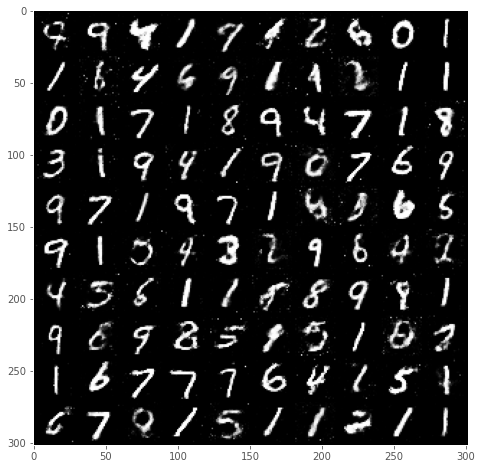

In [71]:
# show output after epochs training
plt.figure(figsize=(8, 8))
plt.grid(False)
plt.imshow(np.asarray(Image.open(os.path.join(sample_dir, "fake_images-0225.png"))))

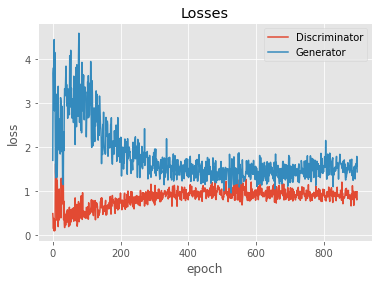

In [72]:
# show the discrimator loss and generator loss
plt.plot(d_losses, "-")
plt.plot(g_losses, "-")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Discriminator", "Generator"])
plt.title("Losses");

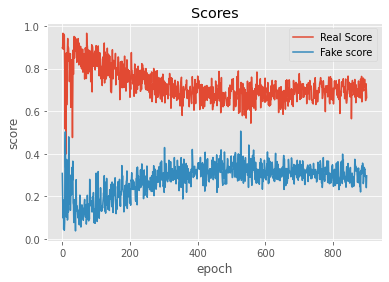

In [73]:
# plot the accuracy of discrimator
plt.plot(real_scores, "-")
plt.plot(fake_scores, "-")
plt.xlabel("epoch")
plt.ylabel("score")
plt.legend(["Real Score", "Fake score"])
plt.title("Scores");

## 2. DCGAN

*Source: <a href="https://arxiv.org/pdf/1511.06434v2.pdf" target="_blank">Radford, Alec, Luke Metz, and Soumith Chintala. "Unsupervised representation learning with deep convolutional generative adversarial networks." arXiv preprint arXiv:1511.06434 (2015)</a>.*

The goal of this part is to enhance your results achieved in the part one with DCGAN. Feel free to reuse your code, improve architecture or training scheme, etc.

In [115]:
class CFG:
    batch_size = 128
    num_epochs = 300
    workers = 4
    seed = 2021
    image_size = 64
    download = True
    dataroot = "data"
    nc = 3  ## number of chanels
    ngf = 64  # Size of feature maps in generator
    nz = 100  # latent random input vector
    ndf = 64  # Size of feature maps in discriminator
    lr = 0.0002
    device = "cuda" if torch.cuda.is_available() else "cpu"
    sample_dir = "./images/"


if not os.path.exists(CFG.sample_dir):
    os.makedirs(CFG.sample_dir)

cifar_dataset = CIFAR10(
    root=CFG.dataroot,
    download=CFG.download,
    transform=transforms.Compose(
        [
            transforms.Resize([CFG.image_size, CFG.image_size]),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)

Files already downloaded and verified


Label:  6


(array([ 3.,  6., 52., 36.,  6.,  4., 12., 40., 40.,  7.,  2.,  6., 22.,
        32., 32.]),
 array([-0.8745098 , -0.8112418 , -0.74797386, -0.68470585, -0.6214379 ,
        -0.5581699 , -0.49490196, -0.43163398, -0.36836597, -0.305098  ,
        -0.24183004, -0.17856206, -0.11529408, -0.0520261 ,  0.01124188,
         0.07450986], dtype=float32),
 <a list of 15 Patch objects>)

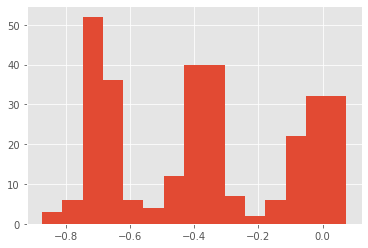

In [116]:
img, label = cifar_dataset[0]
print("Label: ", label)
plt.hist(img[:, 5:15, 5:15].flatten(), bins=15)

In [117]:
# unnormalization image from range (-1)-1 to range 0-1 to display it
def denorm(img):
    # write your code
    denorm_img = (img + 1.) / 2 
    return denorm_img
# show  image sample with matplotlib


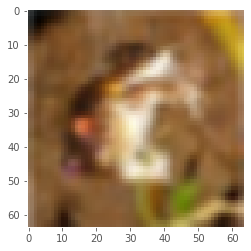

In [118]:
plt.grid(False)
plt.imshow(denorm(img).transpose(0, -1).numpy())

In [164]:
# create the dataloader
dataloader = DataLoader(
    cifar_dataset,
    batch_size=CFG.batch_size,
    shuffle=True,
    num_workers=4,
    drop_last=True
)

### DCGAN implementation

In [165]:
class DCGenerator(nn.Module):
    def __init__(self, nc, nz, ngf):
        # ConvTranspose2d - BatchNorm - Relu -ConvTranspose2d - BatchNorm - Relu -ConvTranspose2d - BatchNorm - Relu
        # ConvTranspose2d - BatchNorm - Relu - ConvTranspose2d - Tanh
        super(DCGenerator, self).__init__()
        ##
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False)
            # state size. (nc) x 64 x 64
        )

    def forward(self, x):
        ##
        x = self.main(x)
        return F.tanh(x)


class DCDiscriminator(nn.Module):
    def __init__(self, nc, ndf):
        # conv2d - leaky - conv2d - batchnorm - leaky - conv2d - batchnorm - leaky - conv - batchnorm - leaky - conv2d
        super(DCDiscriminator, self).__init__()
        ##
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False)
        )

    def forward(self, x):
        ##
        x = self.main(x)
        return F.sigmoid(x)

In [166]:
# create new Generator model
DCG = DCGenerator(CFG.nc, CFG.nz, CFG.ngf).to(device)

# create new Discriminator model
DCD = DCDiscriminator(CFG.nc, CFG.ndf).to(device)

In [167]:
# show the output of model
y = DCG(torch.randn(2, CFG.nz, 1, 1).to(device))
y.shape

torch.Size([2, 3, 64, 64])

In [168]:
# define the criterion is nn.BCELoss()
criterion = nn.BCELoss()

## Define the optimizer for generator and discrimator
G_optimizer = torch.optim.AdamW(DCG.parameters(), lr=CFG.lr)
D_optimizer = torch.optim.AdamW(DCD.parameters(), lr=CFG.lr)

In [169]:
# feel free to reuse your training functions

def reset_grad():
    ## reset gradient for optimizer of generator and discrimator
    G_optimizer.zero_grad()
    D_optimizer.zero_grad()

def train_discriminator(D_model, G_model, images):
  
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(CFG.batch_size).to(device)
    fake_labels = torch.zeros(CFG.batch_size).to(device)
        
    
    outputs = D_model(images)
    # Loss for real images
    
    real_score = outputs.view(-1)
    #real_score = outputs.squeeze().unsqueeze(1)

    # Loss for fake images
    z = torch.randn(CFG.batch_size, CFG.nz, 1, 1).to(device)
    fake_images = G_model(z)
    outputs = D_model(fake_images)

    fake_score = outputs.view(-1)
    #fake_score = outputs.squeeze().unsqueeze(1)

    # Sum losses
    real_loss = criterion(real_score, real_labels)
    fake_loss = criterion(fake_score, fake_labels)
    
    d_loss = real_loss + fake_loss

    # Reset gradients
    reset_grad()

    # Compute gradients
    d_loss.backward()

    # Adjust the parameters using backprop
    D_optimizer.step()
    
    return d_loss, real_score, fake_score

def train_generator(G_model, D_model):
    # Generate fake images and calculate loss
    #z = torch.randn(batch_size, latent_size).to(device)
    z = torch.Tensor(np.random.normal(0, 1, (CFG.batch_size, CFG.nz, 1, 1))).to(device)
    fake_images = G_model(z)
    labels = torch.ones(batch_size).to(device)
    # calculate the generator loss
    
    g_loss = criterion(D_model(fake_images).view(-1), labels)
    #g_loss = criterion(D_model(fake_images).squeeze().unsqueeze(1), labels)

    # Reset gradients
    reset_grad()

    # Backprop and optimize
    g_loss.backward()
    
    G_optimizer.step()
    

    return g_loss, fake_images

### Start the training proccess

In [170]:
def save_fake_images_cifar(DCG_model, index):
    sample_vectors = torch.randn(CFG.batch_size, CFG.nz, 1, 1).to(CFG.device)
    fake_images = DCG_model(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 3, 64, 64)
    fake_fname = "fake_images-{0:0=4d}.png".format(index)
    print("Saving", fake_fname)
    save_image(
        denorm(fake_images), os.path.join(CFG.sample_dir, fake_fname), nrow=10
    )

In [171]:
%%time
device = CFG.device
num_epochs = CFG.num_epochs
batch_size = CFG.batch_size

total_step = len(dataloader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
DCG.to(device)
DCD.to(device)

for epoch in tqdm(range(num_epochs)):
    for i, (images, _) in enumerate(dataloader):
        # Load a batch & transform to vectors
        images = images.to(device)
        #images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator
        d_loss, real_score, fake_score = train_discriminator(DCD, DCG, images)

        # Train the generator
        g_loss, fake_images = train_generator(DCG, DCD)

        # Inspect the losses
        if (i + 1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print(
                "Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}".format(
                    epoch,
                    num_epochs,
                    i + 1,
                    total_step,
                    d_loss.item(),
                    g_loss.item(),
                    real_score.mean().item(),
                    fake_score.mean().item(),
                )
            )
    # Sample and save images
    save_fake_images_cifar(DCG, epoch + 1)

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch [0/300], Step [200/390], d_loss: 0.0080, g_loss: 8.7842, D(x): 1.00, D(G(z)): 0.01


  0%|          | 1/300 [01:29<7:25:12, 89.34s/it]

Saving fake_images-0001.png
Epoch [1/300], Step [200/390], d_loss: 0.0305, g_loss: 7.7398, D(x): 1.00, D(G(z)): 0.02


  1%|          | 2/300 [03:00<7:28:07, 90.23s/it]

Saving fake_images-0002.png
Epoch [2/300], Step [200/390], d_loss: 0.0111, g_loss: 7.1267, D(x): 0.99, D(G(z)): 0.01


  1%|          | 3/300 [04:32<7:30:22, 90.98s/it]

Saving fake_images-0003.png
Epoch [3/300], Step [200/390], d_loss: 0.0333, g_loss: 8.2622, D(x): 0.99, D(G(z)): 0.02
Saving fake_images-0004.png


  1%|▏         | 4/300 [06:04<7:30:57, 91.41s/it]

Epoch [4/300], Step [200/390], d_loss: 0.0120, g_loss: 6.5551, D(x): 0.99, D(G(z)): 0.00


  2%|▏         | 5/300 [07:36<7:30:52, 91.70s/it]

Saving fake_images-0005.png
Epoch [5/300], Step [200/390], d_loss: 0.0054, g_loss: 9.4910, D(x): 1.00, D(G(z)): 0.00


  2%|▏         | 6/300 [09:07<7:29:09, 91.67s/it]

Saving fake_images-0006.png
Epoch [6/300], Step [200/390], d_loss: 0.0025, g_loss: 13.8588, D(x): 1.00, D(G(z)): 0.00


  2%|▏         | 7/300 [10:39<7:27:38, 91.67s/it]

Saving fake_images-0007.png
Epoch [7/300], Step [200/390], d_loss: 1.2745, g_loss: 7.0570, D(x): 1.00, D(G(z)): 0.54


  3%|▎         | 8/300 [12:11<7:26:21, 91.72s/it]

Saving fake_images-0008.png
Epoch [8/300], Step [200/390], d_loss: 0.0336, g_loss: 8.2152, D(x): 0.97, D(G(z)): 0.00


  3%|▎         | 9/300 [13:43<7:24:40, 91.69s/it]

Saving fake_images-0009.png
Epoch [9/300], Step [200/390], d_loss: 0.0040, g_loss: 9.1350, D(x): 1.00, D(G(z)): 0.00


  3%|▎         | 10/300 [15:14<7:23:25, 91.74s/it]

Saving fake_images-0010.png
Epoch [10/300], Step [200/390], d_loss: 0.0402, g_loss: 8.3300, D(x): 0.97, D(G(z)): 0.00


  4%|▎         | 11/300 [16:46<7:21:52, 91.74s/it]

Saving fake_images-0011.png
Epoch [11/300], Step [200/390], d_loss: 0.0164, g_loss: 9.3554, D(x): 1.00, D(G(z)): 0.01


  4%|▍         | 12/300 [18:18<7:20:41, 91.81s/it]

Saving fake_images-0012.png
Epoch [12/300], Step [200/390], d_loss: 0.0177, g_loss: 8.2043, D(x): 0.99, D(G(z)): 0.01


  4%|▍         | 13/300 [19:50<7:19:01, 91.78s/it]

Saving fake_images-0013.png
Epoch [13/300], Step [200/390], d_loss: 0.0783, g_loss: 10.4120, D(x): 0.95, D(G(z)): 0.01


  5%|▍         | 14/300 [21:22<7:17:23, 91.76s/it]

Saving fake_images-0014.png
Epoch [14/300], Step [200/390], d_loss: 0.0047, g_loss: 9.8385, D(x): 1.00, D(G(z)): 0.00


  5%|▌         | 15/300 [22:53<7:16:06, 91.81s/it]

Saving fake_images-0015.png
Epoch [15/300], Step [200/390], d_loss: 0.0083, g_loss: 9.5603, D(x): 0.99, D(G(z)): 0.00


  5%|▌         | 16/300 [24:26<7:14:52, 91.87s/it]

Saving fake_images-0016.png
Epoch [16/300], Step [200/390], d_loss: 0.0104, g_loss: 14.1990, D(x): 1.00, D(G(z)): 0.01


  6%|▌         | 17/300 [25:57<7:13:01, 91.81s/it]

Saving fake_images-0017.png
Epoch [17/300], Step [200/390], d_loss: 0.0111, g_loss: 5.8096, D(x): 0.99, D(G(z)): 0.00


  6%|▌         | 18/300 [27:29<7:11:19, 91.77s/it]

Saving fake_images-0018.png
Epoch [18/300], Step [200/390], d_loss: 0.1222, g_loss: 6.4386, D(x): 0.91, D(G(z)): 0.01


  6%|▋         | 19/300 [29:01<7:10:00, 91.82s/it]

Saving fake_images-0019.png
Epoch [19/300], Step [200/390], d_loss: 0.0279, g_loss: 7.6556, D(x): 1.00, D(G(z)): 0.02


  7%|▋         | 20/300 [30:33<7:08:27, 91.81s/it]

Saving fake_images-0020.png
Epoch [20/300], Step [200/390], d_loss: 0.0082, g_loss: 8.5970, D(x): 1.00, D(G(z)): 0.01


  7%|▋         | 21/300 [32:04<7:07:02, 91.84s/it]

Saving fake_images-0021.png
Epoch [21/300], Step [200/390], d_loss: 0.0324, g_loss: 7.8506, D(x): 1.00, D(G(z)): 0.03


  7%|▋         | 22/300 [33:36<7:05:20, 91.80s/it]

Saving fake_images-0022.png
Epoch [22/300], Step [200/390], d_loss: 0.1138, g_loss: 7.6530, D(x): 1.00, D(G(z)): 0.09


  8%|▊         | 23/300 [35:08<7:03:30, 91.74s/it]

Saving fake_images-0023.png
Epoch [23/300], Step [200/390], d_loss: 0.0121, g_loss: 6.8450, D(x): 0.99, D(G(z)): 0.00


  8%|▊         | 24/300 [36:40<7:02:10, 91.78s/it]

Saving fake_images-0024.png
Epoch [24/300], Step [200/390], d_loss: 0.0808, g_loss: 7.8863, D(x): 0.99, D(G(z)): 0.04


  8%|▊         | 25/300 [38:11<7:00:35, 91.77s/it]

Saving fake_images-0025.png
Epoch [25/300], Step [200/390], d_loss: 0.0265, g_loss: 9.1041, D(x): 1.00, D(G(z)): 0.02


  9%|▊         | 26/300 [39:43<6:59:02, 91.76s/it]

Saving fake_images-0026.png
Epoch [26/300], Step [200/390], d_loss: 0.2335, g_loss: 7.8452, D(x): 0.86, D(G(z)): 0.00


  9%|▉         | 27/300 [41:15<6:57:25, 91.74s/it]

Saving fake_images-0027.png
Epoch [27/300], Step [200/390], d_loss: 0.0387, g_loss: 4.8739, D(x): 0.98, D(G(z)): 0.01


  9%|▉         | 28/300 [42:47<6:55:53, 91.74s/it]

Saving fake_images-0028.png
Epoch [28/300], Step [200/390], d_loss: 0.0664, g_loss: 2.5005, D(x): 1.00, D(G(z)): 0.06


 10%|▉         | 29/300 [44:18<6:54:22, 91.74s/it]

Saving fake_images-0029.png
Epoch [29/300], Step [200/390], d_loss: 0.0210, g_loss: 7.2612, D(x): 1.00, D(G(z)): 0.01


 10%|█         | 30/300 [45:50<6:52:52, 91.75s/it]

Saving fake_images-0030.png
Epoch [30/300], Step [200/390], d_loss: 0.0069, g_loss: 7.9272, D(x): 1.00, D(G(z)): 0.00


 10%|█         | 31/300 [47:22<6:51:28, 91.78s/it]

Saving fake_images-0031.png
Epoch [31/300], Step [200/390], d_loss: 0.0002, g_loss: 14.0492, D(x): 1.00, D(G(z)): 0.00


 11%|█         | 32/300 [48:54<6:49:53, 91.77s/it]

Saving fake_images-0032.png
Epoch [32/300], Step [200/390], d_loss: 0.0914, g_loss: 3.7089, D(x): 0.99, D(G(z)): 0.07


 11%|█         | 33/300 [50:25<6:48:18, 91.75s/it]

Saving fake_images-0033.png
Epoch [33/300], Step [200/390], d_loss: 0.0221, g_loss: 8.4756, D(x): 0.99, D(G(z)): 0.01


 11%|█▏        | 34/300 [51:57<6:46:50, 91.77s/it]

Saving fake_images-0034.png
Epoch [34/300], Step [200/390], d_loss: 0.0434, g_loss: 4.4440, D(x): 1.00, D(G(z)): 0.04


 12%|█▏        | 35/300 [53:29<6:45:15, 91.76s/it]

Saving fake_images-0035.png
Epoch [35/300], Step [200/390], d_loss: 0.1426, g_loss: 4.6550, D(x): 0.99, D(G(z)): 0.11


 12%|█▏        | 36/300 [55:01<6:43:31, 91.71s/it]

Saving fake_images-0036.png
Epoch [36/300], Step [200/390], d_loss: 0.0138, g_loss: 5.4041, D(x): 1.00, D(G(z)): 0.01


 12%|█▏        | 37/300 [56:32<6:41:42, 91.64s/it]

Saving fake_images-0037.png
Epoch [37/300], Step [200/390], d_loss: 0.0216, g_loss: 6.4388, D(x): 0.99, D(G(z)): 0.01


 13%|█▎        | 38/300 [58:04<6:40:03, 91.62s/it]

Saving fake_images-0038.png
Epoch [38/300], Step [200/390], d_loss: 0.1445, g_loss: 5.9823, D(x): 0.96, D(G(z)): 0.08


 13%|█▎        | 39/300 [59:35<6:38:27, 91.60s/it]

Saving fake_images-0039.png
Epoch [39/300], Step [200/390], d_loss: 0.0110, g_loss: 9.5151, D(x): 0.99, D(G(z)): 0.00


 13%|█▎        | 40/300 [1:01:07<6:37:07, 91.64s/it]

Saving fake_images-0040.png
Epoch [40/300], Step [200/390], d_loss: 0.0089, g_loss: 7.8866, D(x): 0.99, D(G(z)): 0.00


 14%|█▎        | 41/300 [1:02:39<6:35:41, 91.66s/it]

Saving fake_images-0041.png
Epoch [41/300], Step [200/390], d_loss: 0.0107, g_loss: 7.1157, D(x): 1.00, D(G(z)): 0.01


 14%|█▍        | 42/300 [1:04:10<6:34:14, 91.69s/it]

Saving fake_images-0042.png
Epoch [42/300], Step [200/390], d_loss: 0.0008, g_loss: 8.3454, D(x): 1.00, D(G(z)): 0.00


 14%|█▍        | 43/300 [1:05:42<6:33:01, 91.76s/it]

Saving fake_images-0043.png
Epoch [43/300], Step [200/390], d_loss: 0.0425, g_loss: 5.2484, D(x): 1.00, D(G(z)): 0.03


 15%|█▍        | 44/300 [1:07:14<6:31:18, 91.71s/it]

Saving fake_images-0044.png
Epoch [44/300], Step [200/390], d_loss: 0.0957, g_loss: 10.0978, D(x): 0.97, D(G(z)): 0.00


 15%|█▌        | 45/300 [1:08:46<6:29:53, 91.74s/it]

Saving fake_images-0045.png
Epoch [45/300], Step [200/390], d_loss: 0.0183, g_loss: 6.9781, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0046.png


 15%|█▌        | 46/300 [1:10:17<6:28:25, 91.75s/it]

Epoch [46/300], Step [200/390], d_loss: 0.1223, g_loss: 13.8613, D(x): 0.91, D(G(z)): 0.00


 16%|█▌        | 47/300 [1:11:49<6:26:49, 91.74s/it]

Saving fake_images-0047.png
Epoch [47/300], Step [200/390], d_loss: 0.0538, g_loss: 8.4067, D(x): 0.96, D(G(z)): 0.00


 16%|█▌        | 48/300 [1:13:21<6:25:01, 91.67s/it]

Saving fake_images-0048.png
Epoch [48/300], Step [200/390], d_loss: 0.0457, g_loss: 7.4374, D(x): 0.96, D(G(z)): 0.00
Saving fake_images-0049.png


 16%|█▋        | 49/300 [1:14:53<6:23:44, 91.73s/it]

Epoch [49/300], Step [200/390], d_loss: 0.0369, g_loss: 6.3116, D(x): 0.98, D(G(z)): 0.02
Saving fake_images-0050.png


 17%|█▋        | 50/300 [1:16:24<6:22:05, 91.70s/it]

Epoch [50/300], Step [200/390], d_loss: 0.0948, g_loss: 7.5277, D(x): 0.92, D(G(z)): 0.00
Saving fake_images-0051.png


 17%|█▋        | 51/300 [1:18:05<6:21:18, 91.88s/it]


KeyboardInterrupt: ignored

In [152]:
# show your results!

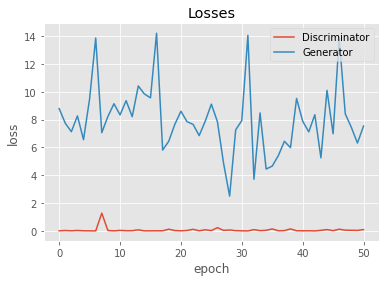

In [172]:
# show the discrimator loss and generator loss
plt.plot(d_losses, "-")
plt.plot(g_losses, "-")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Discriminator", "Generator"])
plt.title("Losses")

Text(0.5, 1.0, 'Scores')

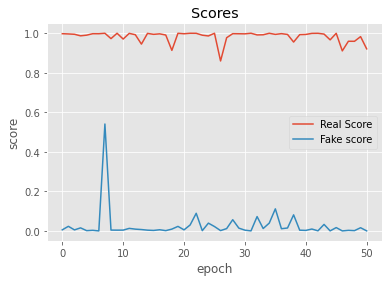

In [173]:
# plot the accuracy of discrimator
plt.plot(real_scores, "-")
plt.plot(fake_scores, "-")
plt.xlabel("epoch")
plt.ylabel("score")
plt.legend(["Real Score", "Fake score"])
plt.title("Scores")

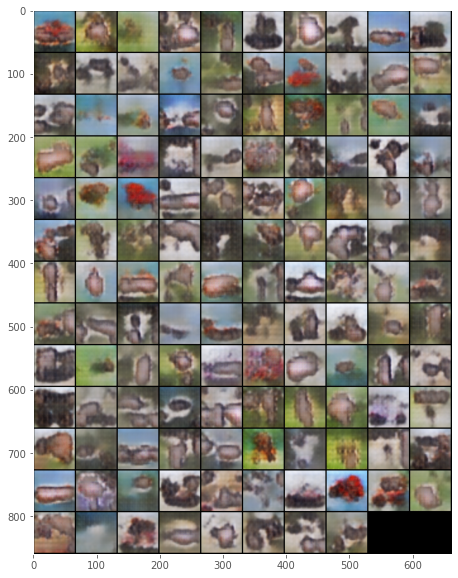

In [175]:
# show output after epochs training
plt.figure(figsize=(10, 10))
plt.grid(False)
plt.imshow(np.asarray(Image.open(os.path.join(sample_dir, "fake_images-0050.png"))))